<font size="5"> Replication project </font>

<font size="4"> Delia Baldassarri and Barum Park, _Was There a Culture War? Partisan Polarization and Secular Trends in US Public Opinion_  </font>

Xiao Sun

POS 6933 Bayesian Statistics and Data Sciences

Spring 2022 

Method: multilevel beta regression modes with a logit link function.

Main outcome of interest is the proportion of liberal responses on each of the issues: overall and specific to each partisan group -- Democrats, Independents, Republicans

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from patsy import dmatrices, dmatrix
import xarray as xr
from scipy.special import expit, logit
from aesara import tensor as at
import pymc.sampling_jax

/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/link/jax/dispatch.py:86: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/sampling_jax.py:34: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [9]:
RANDOM_SEED = 19841987
az.style.use("arviz-darkgrid")

# Data preparation

In [4]:
dt1 = pd.read_csv('m.dat1.csv') # economic issue data
dt1.describe() # pr_agree is the outcome variable

,ID,year,ivars_class,pr_agree,year_1,year_2,year_3,ind,dem,new
count,513.000000,513.000000,513.0,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,256.000000,1997.251462,1.0,0.448603,0.325146,1.193918,1.165287,0.333333,0.333333,8.485380
std,148.234611,10.441856,0.0,0.215654,1.044186,1.496809,3.600886,0.471865,0.471865,5.387003
min,0.000000,1972.000000,1.0,0.015470,-2.200000,0.000000,-10.648000,0.000000,0.000000,1.000000
25%,128.000000,1990.000000,1.0,0.286013,-0.400000,0.040000,-0.064000,0.000000,0.000000,3.000000
50%,256.000000,1996.000000,1.0,0.464548,0.200000,0.360000,0.008000,0.000000,0.000000,8.000000
75%,384.000000,2004.000000,1.0,0.627063,1.000000,1.960000,1.000000,1.000000,1.000000,13.000000
max,512.000000,2016.000000,1.0,0.889112,2.200000,4.840000,10.648000,1.000000,1.000000,18.000000


In [5]:
dt1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513 entries, 0 to 512
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            513 non-null    int64  
 1   year          513 non-null    int64  
 2   i.vars.label  513 non-null    object 
 3   ivars_class   513 non-null    int64  
 4   data.source   513 non-null    object 
 5   pid           513 non-null    object 
 6   pr_agree      513 non-null    float64
 7   year_1        513 non-null    float64
 8   year_2        513 non-null    float64
 9   year_3        513 non-null    float64
 10  ind           513 non-null    int64  
 11  dem           513 non-null    int64  
 12  new           513 non-null    int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 52.2+ KB


# create group number

In [6]:
group = dt1.new.values -1 # 18 groups

In [23]:
group.shape

(513,)

# create and specify variables in the model

In [8]:
df_inter1 = dt1["ind"]*dt1["year_1"] 
df_inter2 = dt1["dem"]*dt1["year_1"] 
df_inter3 = dt1["ind"]*dt1["year_2"] 
df_inter4 = dt1["dem"]*dt1["year_2"] 

In [9]:
df_x = dt1[["ind", "dem", "year_1", "year_2"]]

In [10]:
df_x["inter1"] = df_inter1
df_x["inter2"] = df_inter2
df_x["inter3"] = df_inter3
df_x["inter4"] = df_inter4

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1745770979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x["inter1"] = df_inter1
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1745770979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x["inter2"] = df_inter2
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1745770979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [11]:
df_x["intercept"] = pd.DataFrame({"intercept": np.ones(len(df_x))})

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/570729423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x["intercept"] = pd.DataFrame({"intercept": np.ones(len(df_x))}) # add


In [12]:
X = df_x.values

In [74]:
X.shape

(513, 9)

In [38]:
# dependnet variable, proportion of liberal response
pr_obs = dt1['pr_agree'].values

In [39]:
pr_obs

array([0.52941176, 0.53569825, 0.54373757, 0.44956772, 0.52332913,
       0.64229562, 0.52126022, 0.5200067 , 0.53452111, 0.61562275,
       0.60962056, 0.57461465, 0.61075533, 0.47972973, 0.46953938,
       0.46323529, 0.45454545, 0.48087432, 0.53433997, 0.47119998,
       0.44670882, 0.4754483 , 0.48598628, 0.47779462, 0.39576955,
       0.39783209, 0.34170854, 0.29328165, 0.29322034, 0.28152493,
       0.29624478, 0.3405479 , 0.2141272 , 0.20971922, 0.2909856 ,
       0.28913572, 0.28868984, 0.17182626, 0.17836958, 0.38786765,
       0.39396887, 0.40172043, 0.28601253, 0.40619902, 0.3625192 ,
       0.42699115, 0.3384913 , 0.39949749, 0.43215507, 0.39918318,
       0.39847458, 0.35562259, 0.44706605, 0.32114186, 0.46589411,
       0.44780717, 0.40337866, 0.47133223, 0.33680556, 0.29201102,
       0.20123839, 0.23550725, 0.27741935, 0.28965517, 0.38356164,
       0.26612903, 0.29050279, 0.37209302, 0.32593989, 0.30205449,
       0.37741245, 0.37893789, 0.26789871, 0.44907692, 0.26662

# replicate multi-level Beta model

## Note 1: I should had run multi-level Beta regression but failed and so could not replicate the exact results because I could not use MvNormal to specify the covariance between predictors and could not  use Beta regression to estimate the likelihood in model building.

## Note 2: I changed both MvNormal and Beta to Normal distribution, so that I can run the model. But the results are not good.

## Note 3: I only build the economic domain model for illustration purpose. I will build all domains' models later.


## here is what I can replicate:

In [160]:
coords ={"group": group,
         "X_dim2": np.arange(X.shape[1]),
    "obs": np.arange(len(dt1.pr_agree))}

with pm.Model (coords = coords) as model_eco_or:
    
    group_idx= pm.ConstantData("group_idx", group, dims = "obs") #
    X_c = pm.ConstantData("X_c", X, dims=("obs", "X_dim2"))
    
    
    # Priors
    
    v = pm.HalfCauchy('v', 3,  dims= "obs") 
    
    μ_γ = pm.Normal('μ_γ', 0, 5, shape = 9) 
    
    sd_dist = pm.Exponential.dist(1.0, size = 9)
   
    Ω, _, _ = pm.LKJCholeskyCov('Ω', eta = 2, n = 9, sd_dist = sd_dist)
   
    σ_l = pm.HalfCauchy('σ_l', 3, shape =9)

    Σ_γ = at.basic.AllocDiag()(σ_l)@Ω@at.basic.AllocDiag()(σ_l)
    
    γ_i = pm.Normal('γ_i', mu = μ_γ, sigma = at.diag(Σ_γ), shape = 9) # did not use mvnormal
    
    
    # linear predictor

    μ_it = at.sigmoid(at.dot(X_c, γ_i))[group_idx]

    
    # Likelihood

    y_it = pm.Normal('y_it', mu=μ_it, sigma = v , observed = pr_obs, dims = "obs")# did not use Beta regression. y_it = pm.Normal('y_it', mu=μ_it, sigma = V , observed = pr_obs[group_idx.eval()], dims = "obs")

In [161]:
model_eco_or

In [162]:
for v in model_eco_or.unobserved_RVs:
    print(v, v.eval().shape)

v (513,)
μ_γ (9,)
Ω (45,)
σ_l (9,)
γ_i (9,)
Ω_corr (9, 9)
Ω_stds (9,)


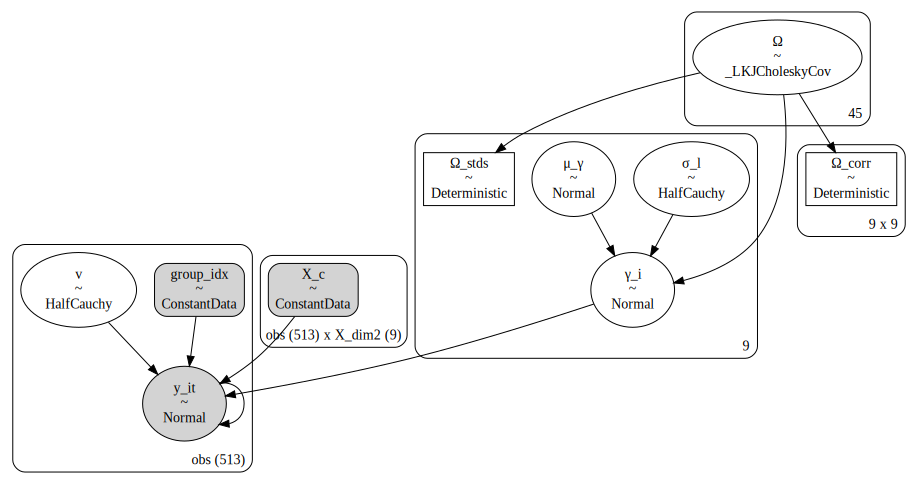

In [171]:
pm.model_to_graphviz(model_eco_or)

In [164]:
with model_eco_or:
    eco_ppc = pm.sample_prior_predictive()

In [166]:
# sampling
with model_eco_or:
    eco_trace_or = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=RANDOM_SEED)# cannot use jax sampling because module 'jax.ops' has no attribute 'index_update'. pm.sampling_jax.sample_numpyro_nuts(draws=6000, tune=1000, target_accept=.98, random_seed=RANDOM_SEED) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, μ_γ, Ω, σ_l, γ_i]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 1222 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree d

In [350]:
eco_trace_or.to_netcdf('eco_trace_or.h5')

'eco_trace_or.h5'

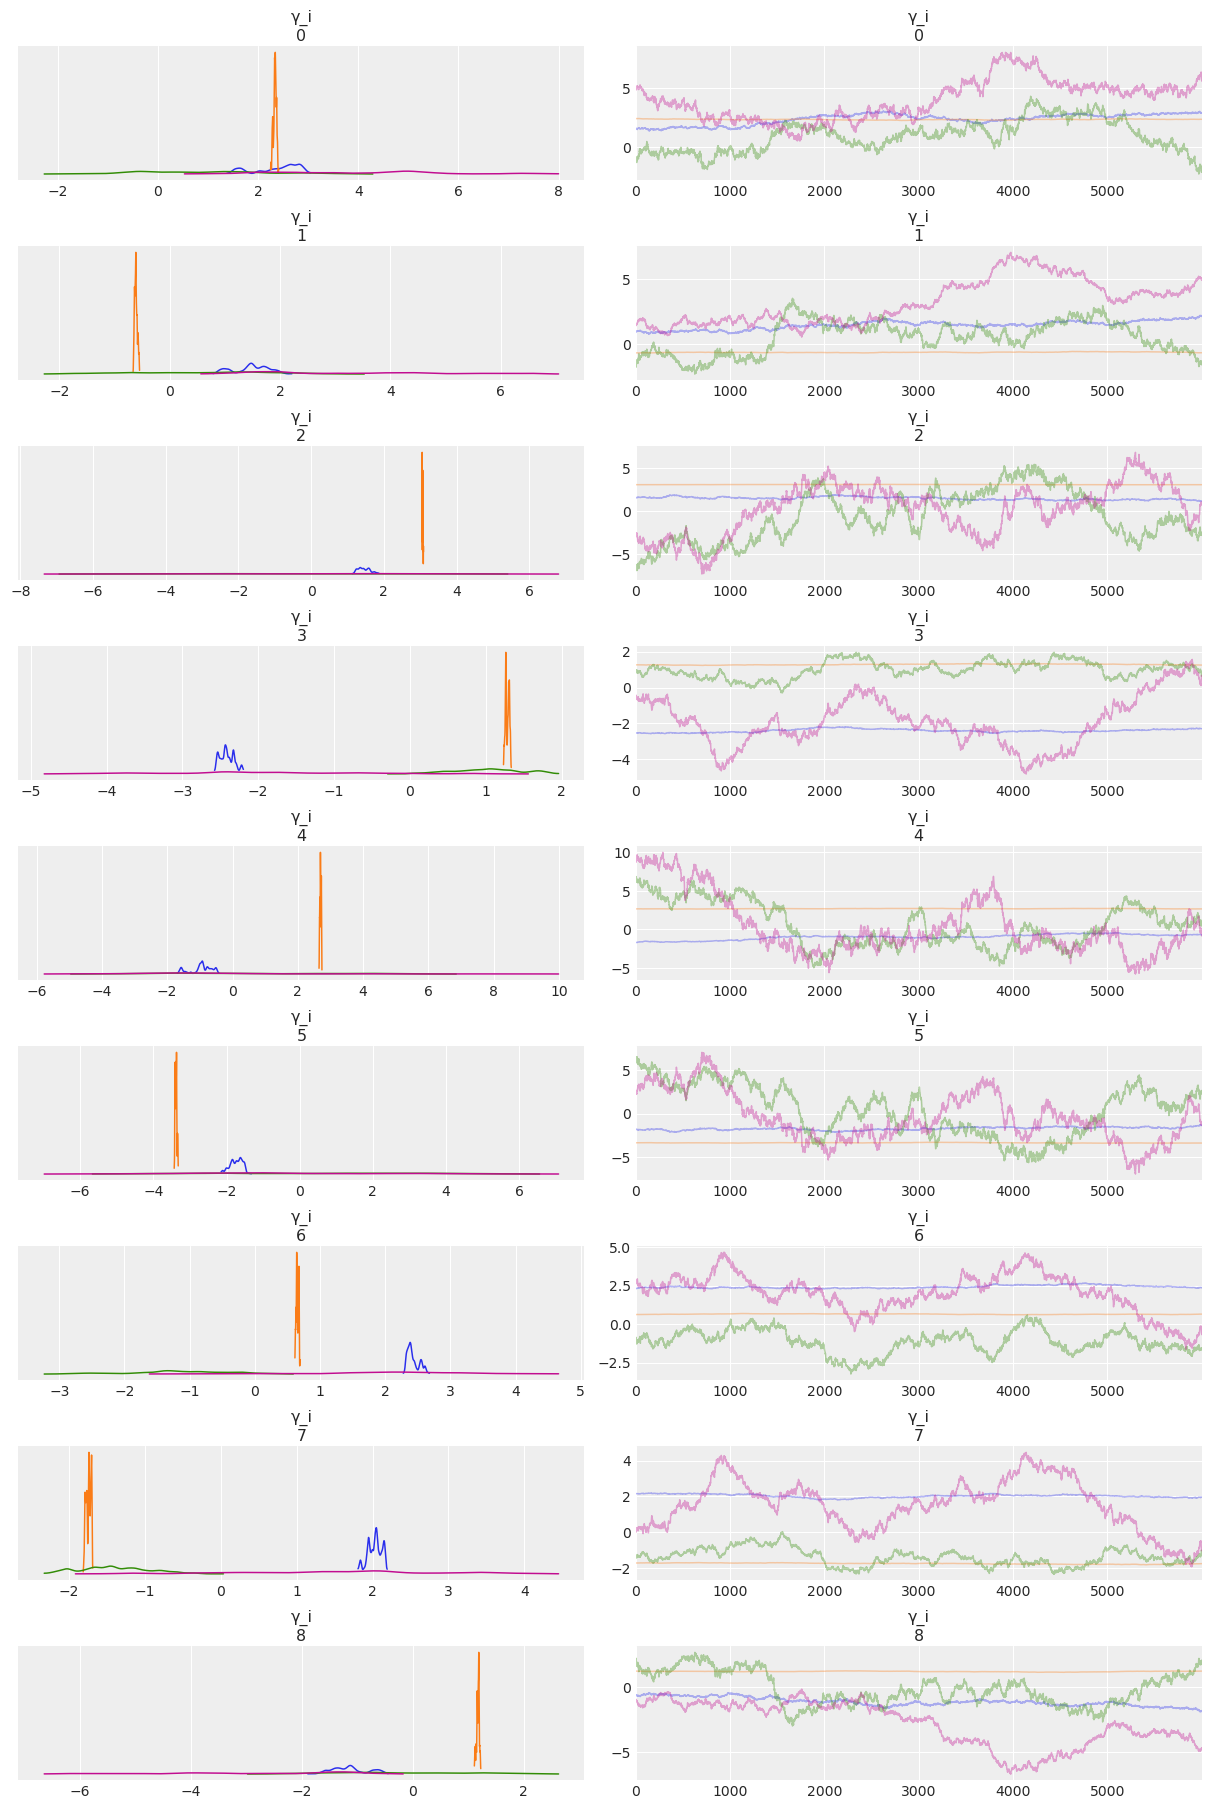

In [167]:
with model_eco_or:
    az.plot_trace(eco_trace_or,var_names=['γ_i'], combined=False,compact=False,
                  divergences=False); # no need to include trace in paper

In [168]:
az.summary(eco_trace_or, var_names=['γ_i'], round_to = 3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
γ_i[0],2.399,1.527,-0.783,5.346,0.652,0.488,6.328,14.120,2.119
γ_i[1],1.162,1.765,-1.500,4.877,0.794,0.598,5.816,14.108,1.881
γ_i[2],1.023,2.493,-4.911,4.025,0.779,0.567,11.102,27.374,1.544
γ_i[3],-0.504,1.823,-2.880,1.900,0.829,0.626,6.415,40.384,1.735
γ_i[4],0.674,2.699,-4.379,5.282,0.693,0.500,20.939,23.431,1.360
γ_i[5],-1.278,2.512,-4.246,4.731,0.804,0.586,10.316,26.937,1.531
γ_i[6],0.994,1.573,-1.950,3.509,0.693,0.521,5.887,31.422,1.876
γ_i[7],0.109,1.842,-2.291,2.487,0.840,0.634,6.218,40.106,1.777
γ_i[8],-0.736,1.811,-4.433,1.899,0.819,0.617,5.769,16.039,1.903


# Extension: build Multi-level Normal Models

## Note: I have changed the models in two major ways. (1) I use more simple uninformative priors; (2) I use different time trends and their interaction terms; (3) extend data, add 2018 GSS data. 

## Economic issue models

In [369]:
# new data
dt1 = pd.read_csv('n.m.dat1.csv')


### Linear time trend model: model_eco_1:    

In [173]:
# specify variables + linear time trends 
X1_df = dt1[["ind", "dem", "year_1"]]
X1_df["inter1"] = df_inter1 # df_inter1 = dt1["ind"]*dt1["year_1"] 
X1_df["inter2"] = df_inter2 # df_inter2 = dt1["dem"]*dt1["year_1"] 
X1_df["intercept"] = pd.DataFrame({"intercept": np.ones(len(df_x))}) # add intercept
X1 = X1_df.values

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1911658230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1_df["inter1"] = df_inter1 # df_inter1 = dt1["ind"]*dt1["year_1"]
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1911658230.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1_df["inter2"] = df_inter2 # df_inter2 = dt1["dem"]*dt1["year_1"]
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1911658230.py:5: SettingWithCopyWarning: 
A value is tryi

In [174]:
X1.shape

(513, 6)

In [186]:
coords1 ={"group": group,
         "X_dim1": np.arange(X1.shape[1]),
    "obs": np.arange(len(dt1.pr_agree))}

In [187]:
with pm.Model (coords = coords1) as model_eco_1:
    
 # create group index
    group_idx= pm.ConstantData("group_idx", group, dims = "obs") 
 # data   
    X_c = pm.ConstantData("X_c", X1, dims=("obs", "X_dim1"))
    
    # Priors

    μ_γ = pm.Normal('μ_γ', 0, 10)
    
    σ_γ = pm.HalfCauchy('σ_l', 3)

    γ_i = pm.Normal('γ_i', mu = μ_γ, sigma = σ_γ, shape=6)
    
    σ_e = pm.Normal('σ_e', 0, 10)
    
    # linear predictor

    μ_it = at.sigmoid(at.dot(X_c, γ_i))[group_idx] 
    
    print(γ_i.eval().shape)
    
    # Likelihood
    print(μ_it.eval().shape)
    y_it = pm.Normal('y_it', mu=μ_it, sigma = σ_e , observed = pr_obs, dims="obs" )# did not use Beta regression. y_it = pm.Normal('y_it', mu=μ_it, sigma = V , observed = pr_obs[group_idx.eval()], dims = "obs") 

(6,)
(513,)


In [188]:
model_eco_1

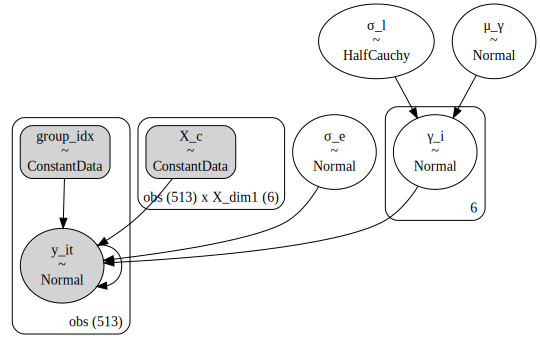

In [189]:
pm.model_to_graphviz(model_eco_1)

In [191]:
with model_eco_1:
    eco_trace1 = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_γ, σ_l, γ_i, σ_e]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 97 seconds.
The acceptance probability does not match the target. It is 0.9344, but should be close to 0.98. Try to increase the numbe

In [351]:
eco_trace1.to_netcdf('eco_trace1.h5')

'eco_trace1.h5'

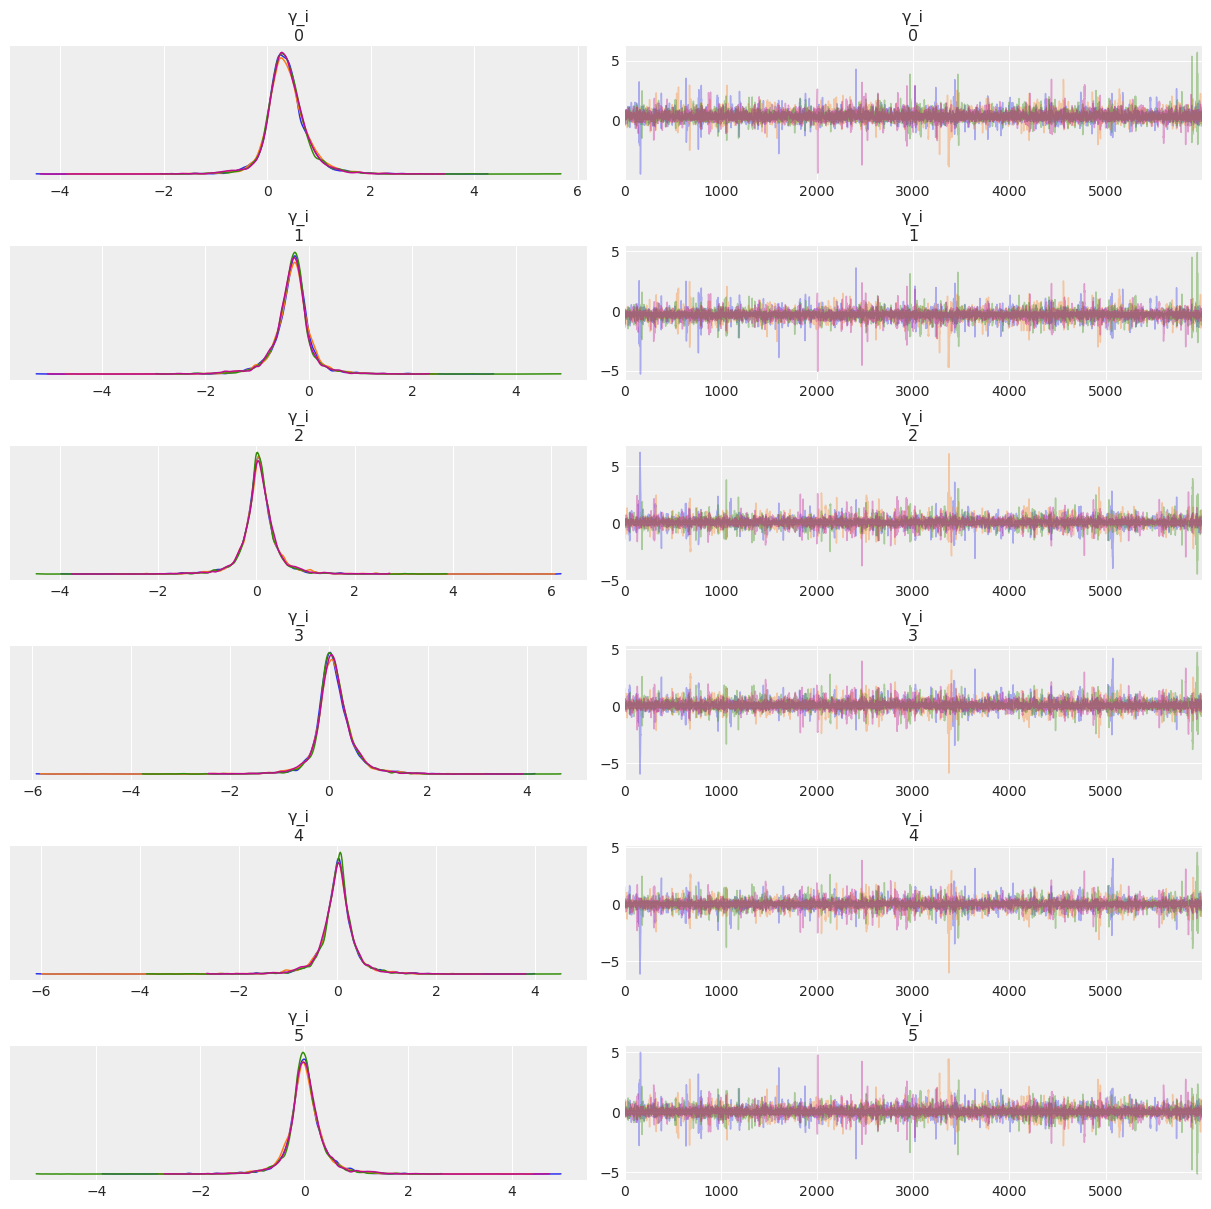

In [192]:
az.plot_trace(eco_trace1,var_names=['γ_i'], combined=False,compact=False,divergences=False); 

In [193]:
az.summary(eco_trace1, var_names=['γ_i'], round_to = 3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
γ_i[0],0.371,0.431,-0.352,1.169,0.005,0.005,9290.764,6881.887,1.001
γ_i[1],-0.326,0.406,-1.079,0.363,0.005,0.005,9819.059,6182.471,1.001
γ_i[2],0.062,0.426,-0.665,0.836,0.006,0.006,7904.812,5032.599,1.001
γ_i[3],0.093,0.437,-0.613,0.914,0.006,0.006,7766.871,5317.569,1.000
γ_i[4],0.003,0.427,-0.759,0.741,0.006,0.006,7895.476,5044.911,1.001
γ_i[5],0.024,0.405,-0.692,0.760,0.005,0.005,9722.949,6208.609,1.001


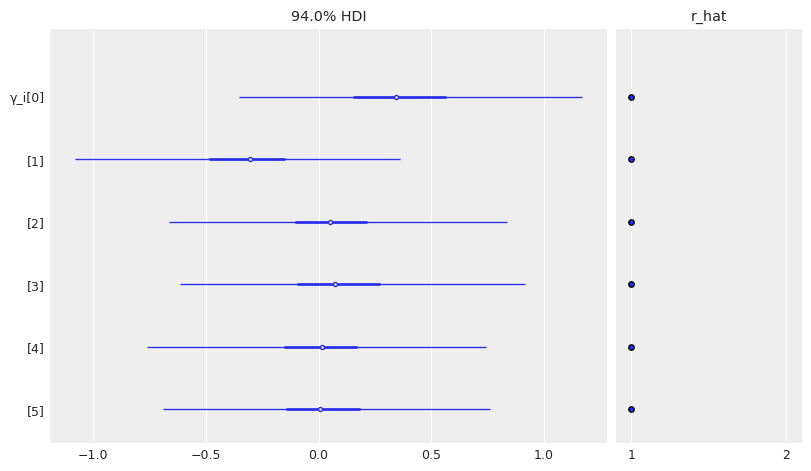

In [194]:
az.plot_forest(eco_trace1,var_names=['γ_i'], r_hat=True, combined=True, textsize=9);

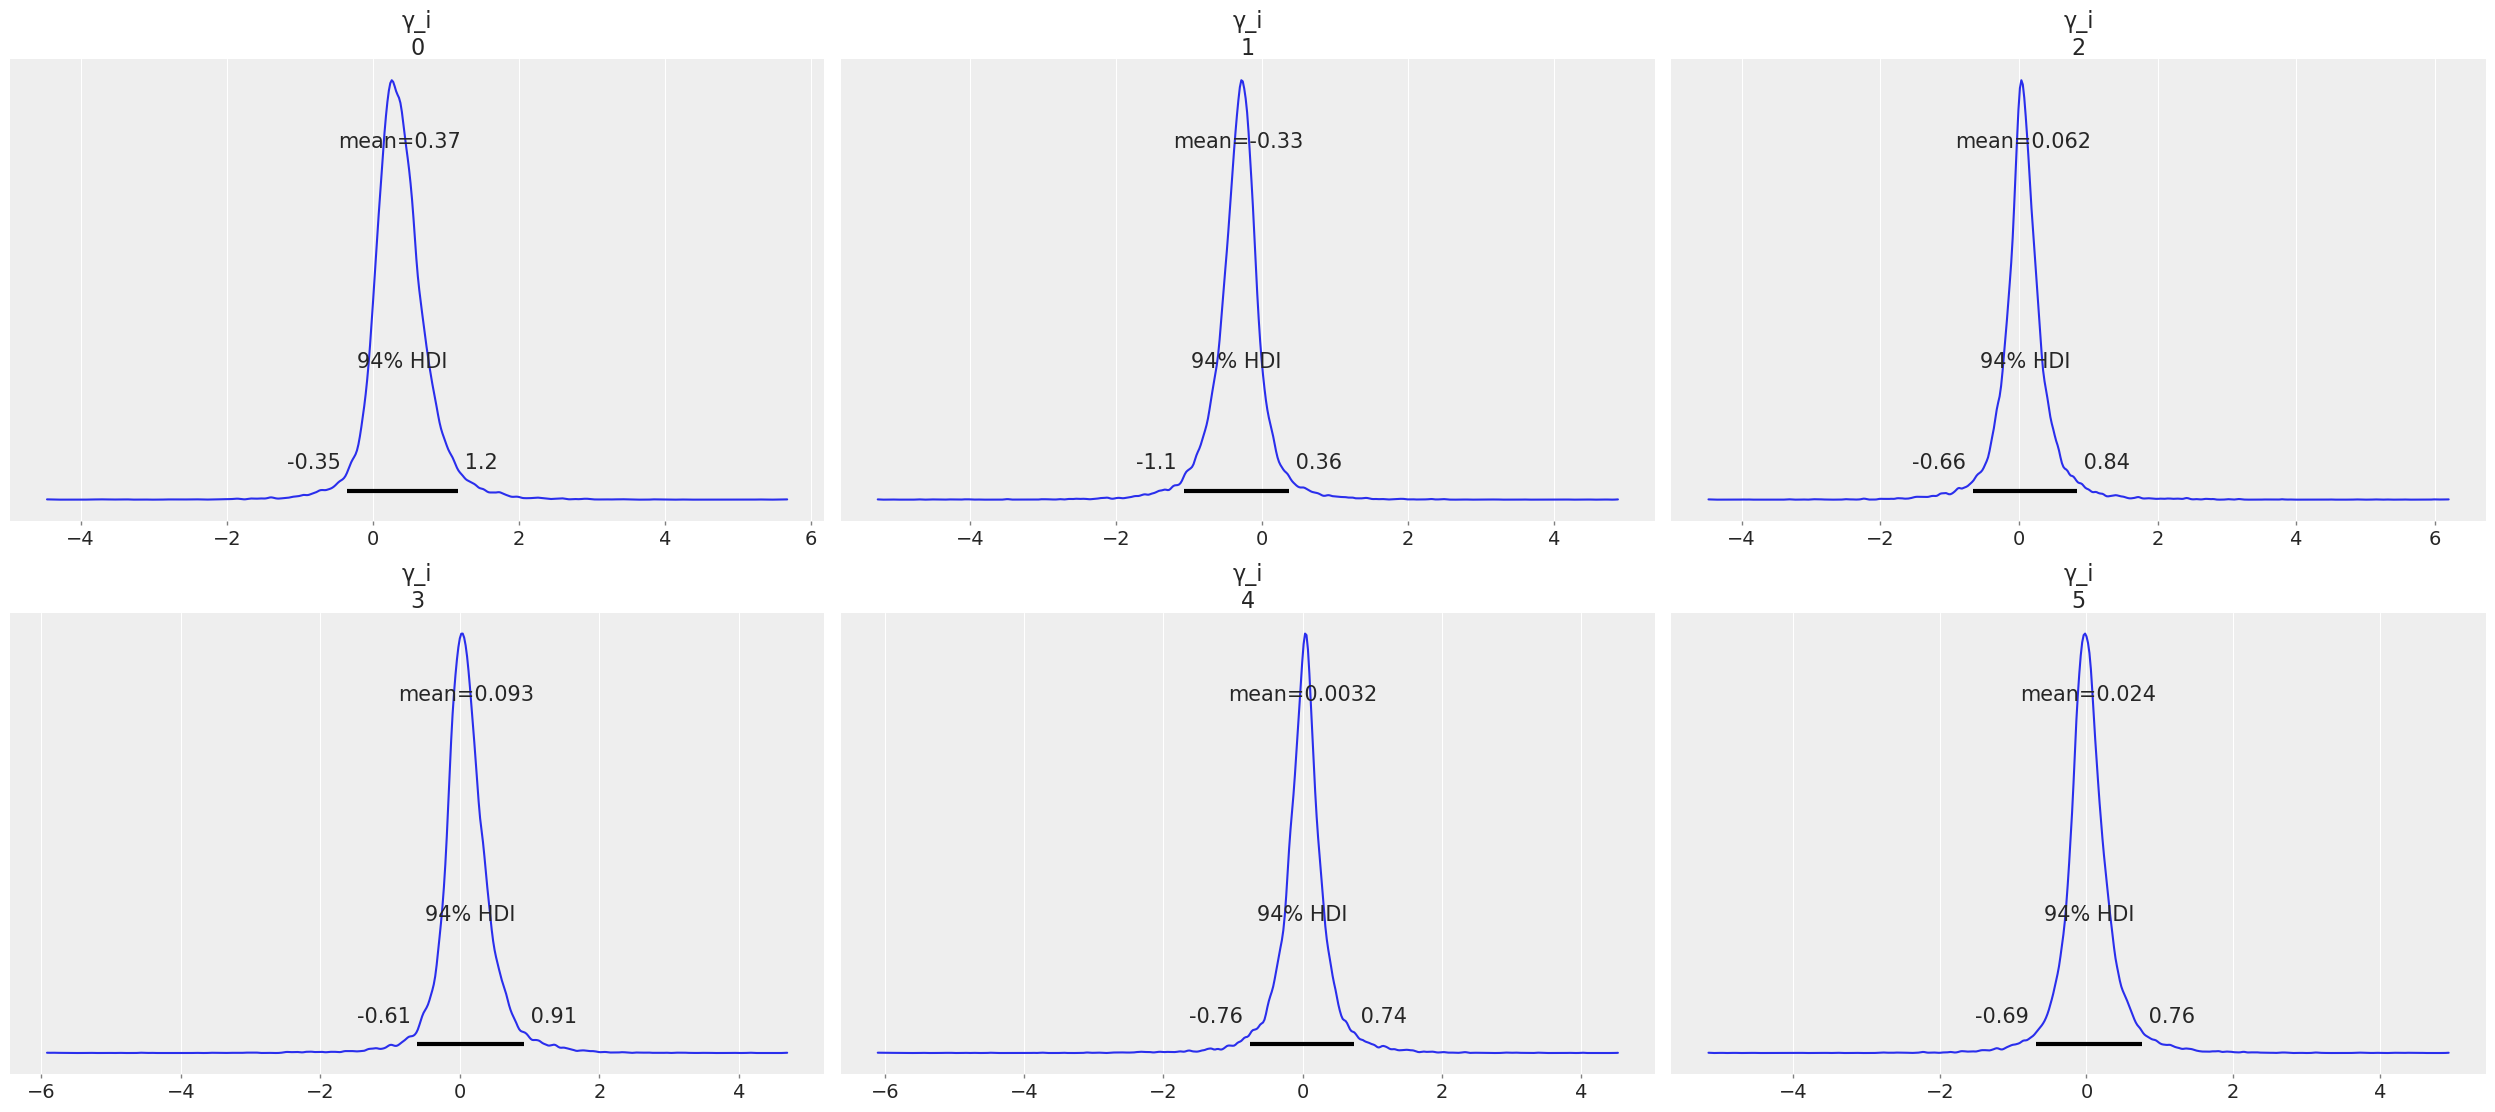

In [195]:
az.plot_posterior(eco_trace1, var_names=['γ_i']);

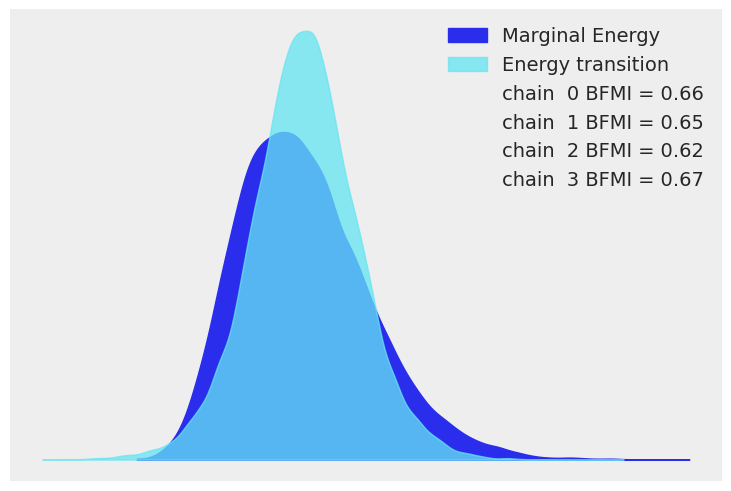

In [196]:
az.plot_energy(eco_trace1);

### Quadratic time trends model: model_eco_2

In [199]:
X2 = df_x.values
coords2 ={"group": group,
         "X_dim2": np.arange(X2.shape[1]),
    "obs": np.arange(len(dt1.pr_agree))}

In [200]:
with pm.Model (coords = coords2) as model_eco_2:
    
    #create group index
    group_idx= pm.ConstantData("group_idx", group, dims = "obs") 
    X_c = pm.ConstantData("X_c", X2, dims=("obs", "X_dim2"))# variables in my model
    
    ## Priors

    μ_γ = pm.Normal('μ_γ', 0, 10)
    
    σ_γ = pm.HalfCauchy('σ_l', 3)

    γ_i = pm.Normal('γ_i', mu = μ_γ, sigma = σ_γ, shape=9)
    
    σ_e = pm.Normal('σ_e', 0, 10)
    
# linear predictor

    μ_it = at.sigmoid(at.dot(X_c, γ_i))[group_idx] 
    
    print(γ_i.eval().shape)
    
# Likelihood
    print(μ_it.eval().shape)
    y_it = pm.Normal('y_it', mu=μ_it, sigma = σ_e , observed = pr_obs, dims="obs" )# did not use Beta regression. y_it = pm.Normal('y_it', mu=μ_it, sigma = V , observed = pr_obs[group_idx.eval()], dims = "obs")
    

(9,)
(513,)


In [201]:
model_eco_2

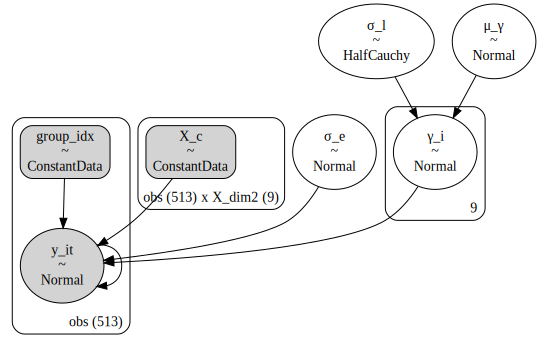

In [202]:
pm.model_to_graphviz(model_eco_2)

In [204]:
with model_eco_2:
    eco_trace2 = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_γ, σ_l, γ_i, σ_e]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 138 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [352]:
eco_trace2.to_netcdf('eco_trace2.h5')

'eco_trace2.h5'

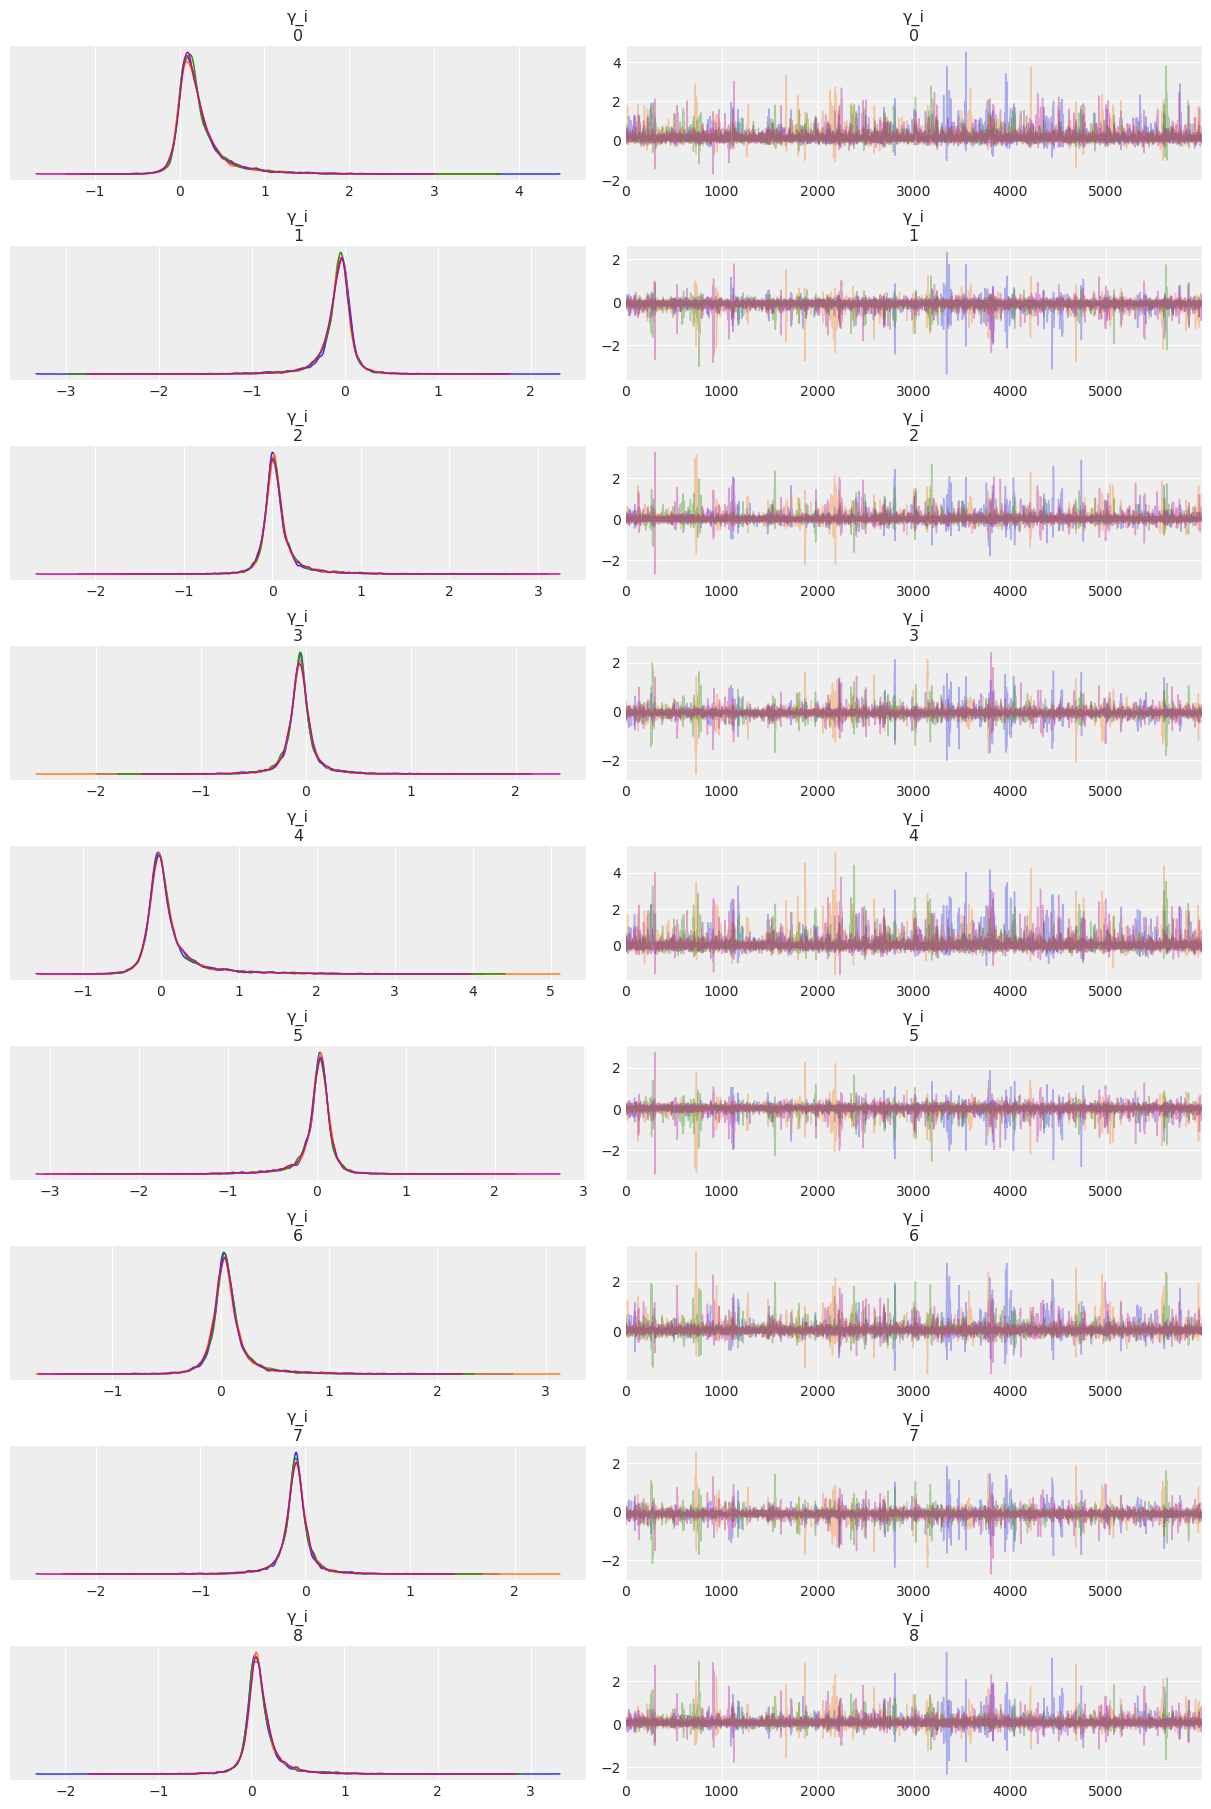

In [155]:
with model_eco_2:
    az.plot_trace(eco_trace2,var_names=['γ_i'], combined=False,compact=False,
                  divergences=False); 

In [156]:
az.summary(eco_trace2, var_names=['γ_i'], round_to = 3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
γ_i[0],0.230,0.319,-0.181,0.842,0.006,0.005,4179.698,2949.807,1.002
γ_i[1],-0.093,0.229,-0.491,0.255,0.003,0.003,8537.340,3088.626,1.001
γ_i[2],0.061,0.243,-0.293,0.510,0.004,0.003,6949.789,2760.772,1.001
γ_i[3],-0.055,0.199,-0.388,0.295,0.002,0.003,9324.789,4016.212,1.002
γ_i[4],0.108,0.402,-0.408,0.862,0.009,0.006,3968.129,2578.873,1.002
γ_i[5],-0.009,0.243,-0.455,0.351,0.004,0.003,7113.324,2771.630,1.002
γ_i[6],0.080,0.237,-0.287,0.492,0.004,0.003,5664.708,2422.526,1.002
γ_i[7],-0.097,0.200,-0.443,0.237,0.002,0.003,9356.639,4102.606,1.002
γ_i[8],0.100,0.227,-0.237,0.501,0.003,0.003,8094.652,3102.468,1.001


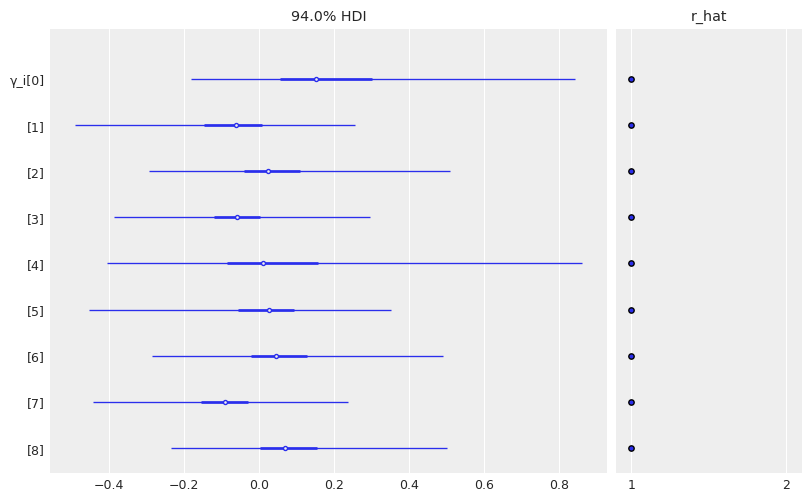

In [157]:
az.plot_forest(eco_trace2,var_names=['γ_i'], r_hat=True, combined=True, textsize=9);

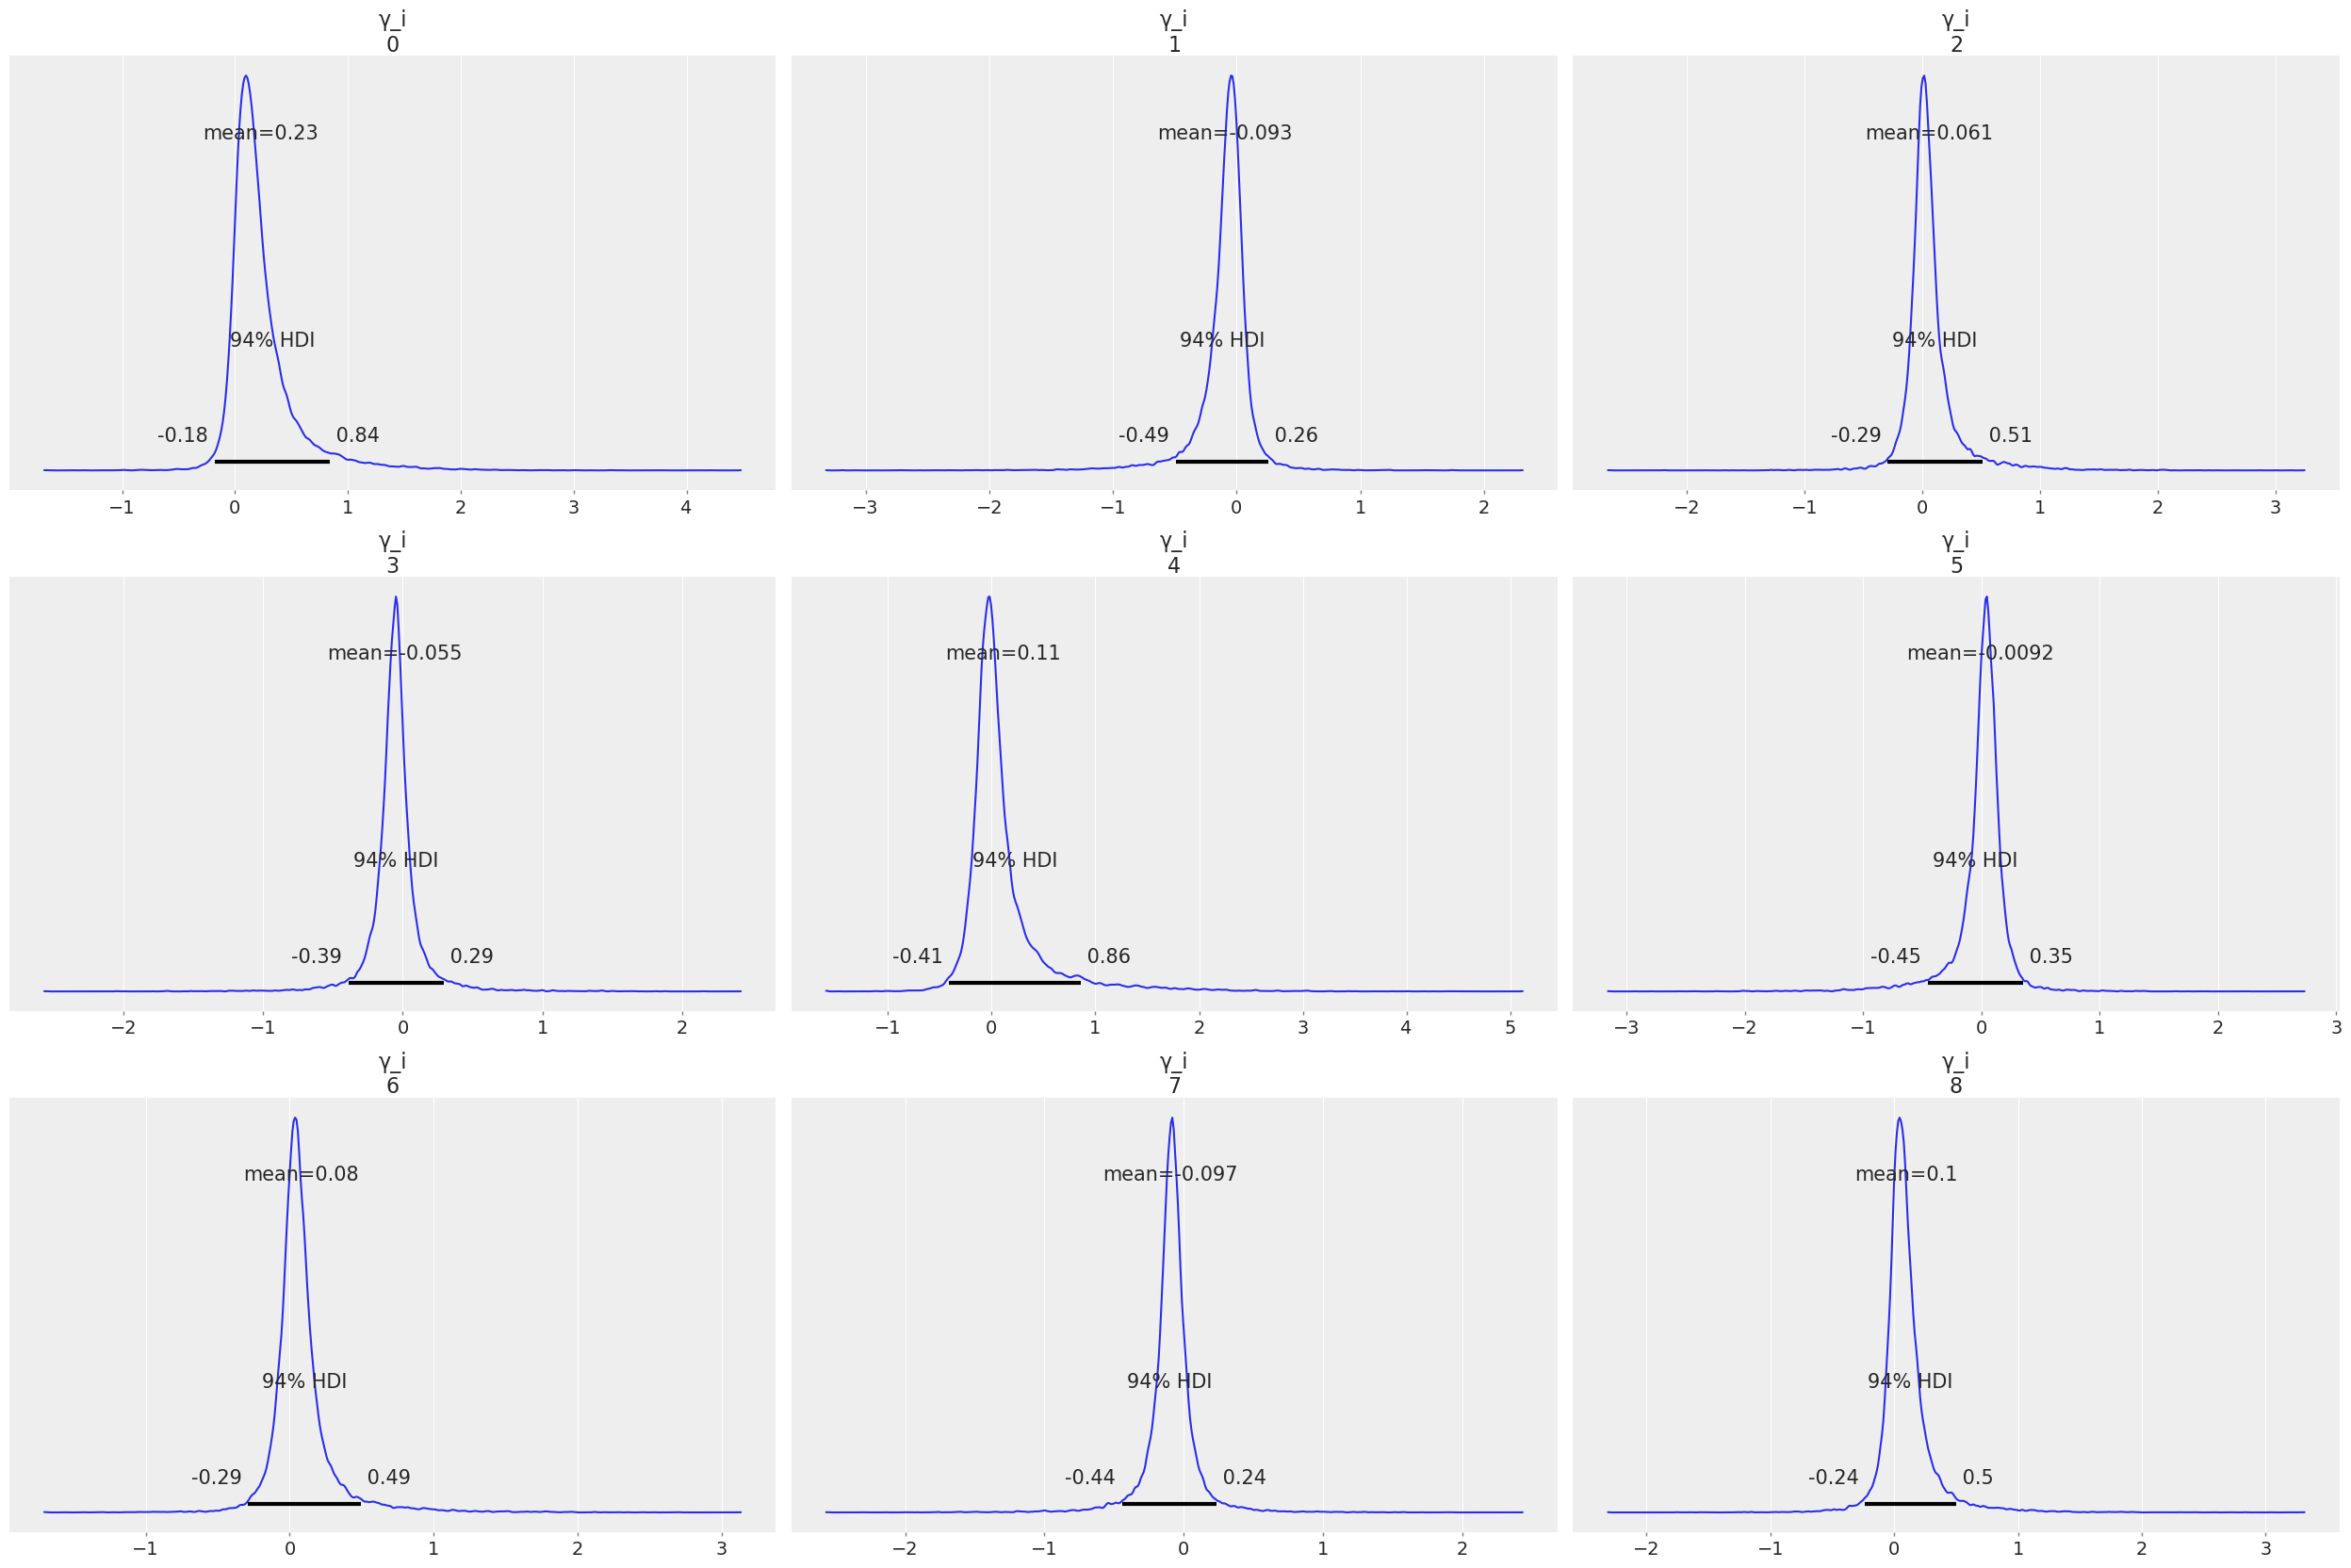

In [159]:
az.plot_posterior(eco_trace2, var_names=['γ_i']);

### Cubic time trend model: model_eco_3:    

In [205]:
X3_df = dt1[["ind", "dem", "year_1", "year_2", "year_3"]]

#add interaction terms 5, 6
df_inter5 = dt1["ind"]*dt1["year_3"] 
df_inter6 = dt1["dem"]*dt1["year_3"] 

X3_df["inter1"] = df_inter1 # df_inter1 = dt1["ind"]*dt1["year_1"] 
X3_df["inter2"] = df_inter2 # df_inter2 = dt1["dem"]*dt1["year_1"] 
X3_df["inter3"] = df_inter3
X3_df["inter4"] = df_inter4
X3_df["inter5"] = df_inter5
X3_df["inter6"] = df_inter6

# add intercept
X3_df["intercept"] = pd.DataFrame({"intercept": np.ones(len(df_x))}) # add intercept

# values
X3 = X3_df.values

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1685724053.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3_df["inter1"] = df_inter1 # df_inter1 = dt1["ind"]*dt1["year_1"]
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1685724053.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3_df["inter2"] = df_inter2 # df_inter2 = dt1["dem"]*dt1["year_1"]
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1685724053.py:9: SettingWithCopyWarning: 
A value is tryi

In [208]:
X3.shape # shape =12

(513, 12)

In [209]:
coords3 ={"group": group,
         "X_dim3": np.arange(X3.shape[1]),
    "obs": np.arange(len(dt1.pr_agree))}


In [211]:
with pm.Model (coords = coords3) as model_eco_3:
    
    #create group index
    group_idx= pm.ConstantData("group_idx", group, dims = "obs") 
    X_c = pm.ConstantData("X_c", X3, dims=("obs", "X_dim3"))# variables in my model
    
    ## Priors

    μ_γ = pm.Normal('μ_γ', 0, 10)
    
    σ_γ = pm.HalfCauchy('σ_l', 3)

    γ_i = pm.Normal('γ_i', mu = μ_γ, sigma = σ_γ, shape=12)
    
    σ_e = pm.Normal('σ_e', 0, 10)
    
# linear predictor

    μ_it = at.sigmoid(at.dot(X_c, γ_i))[group_idx] 
    
    print(γ_i.eval().shape)
    
# Likelihood
    print(μ_it.eval().shape)
    y_it = pm.Normal('y_it', mu=μ_it, sigma = σ_e , observed = pr_obs, dims="obs" )# did not use Beta regression. y_it = pm.Normal('y_it', mu=μ_it, sigma = V , observed = pr_obs[group_idx.eval()], dims = "obs")

    eco_trace3 = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


(12,)
(513,)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_γ, σ_l, γ_i, σ_e]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 375 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain rea

In [353]:
eco_trace3.to_netcdf('eco_trace3.h5')

'eco_trace3.h5'

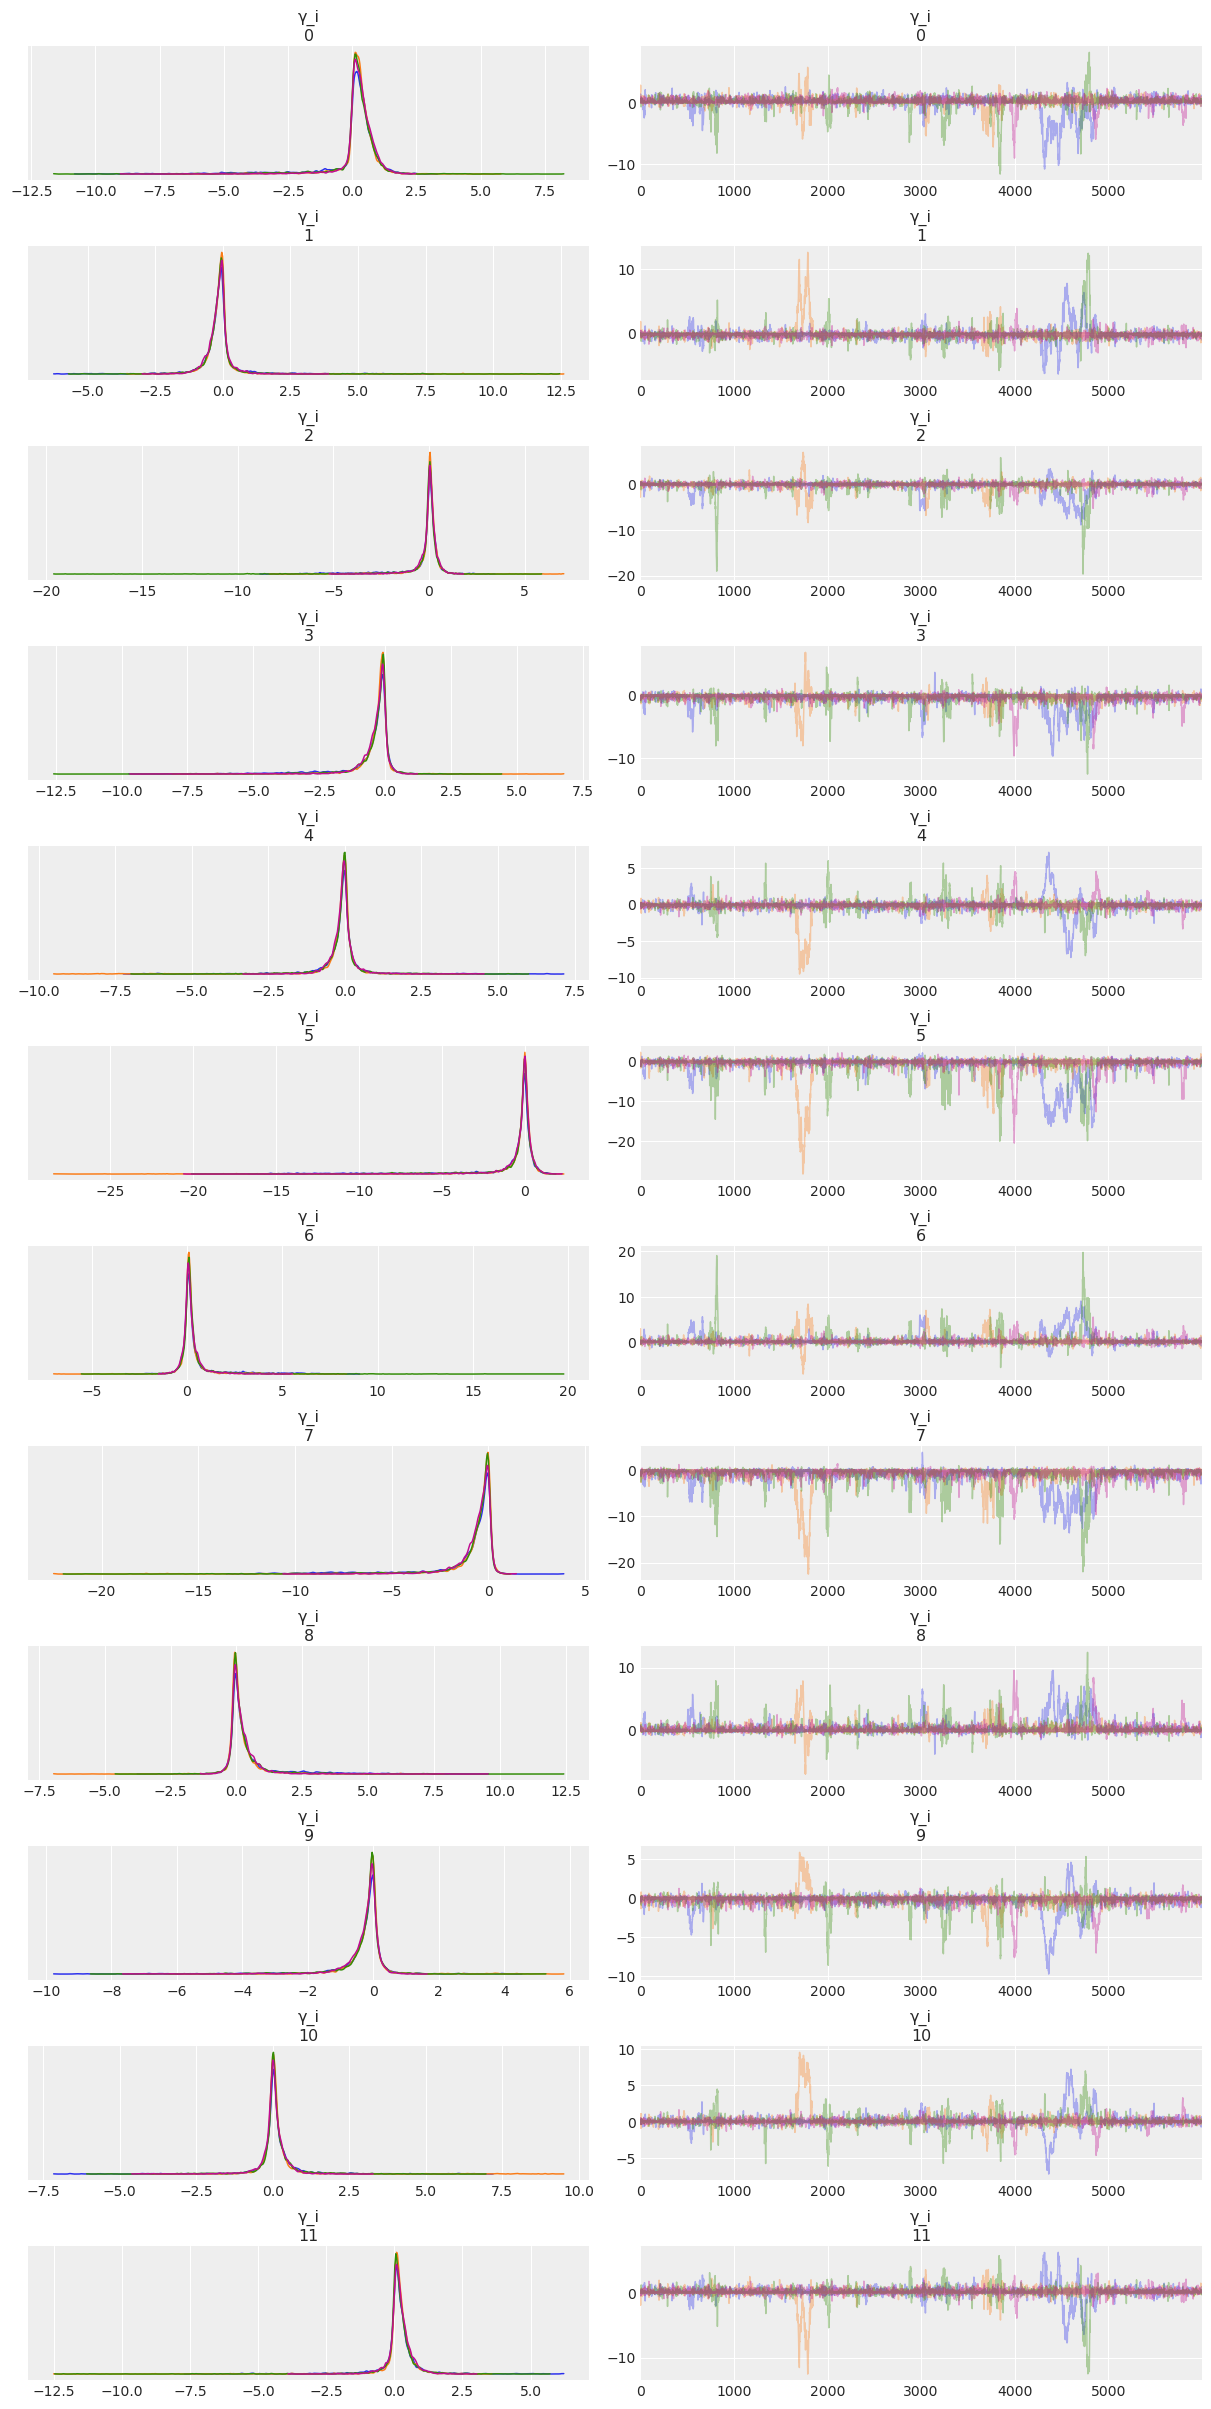

In [212]:
az.plot_trace(eco_trace3,var_names=['γ_i'], combined=False,compact=False,divergences=False); 

In [213]:
az.summary(eco_trace3, var_names=['γ_i'], round_to = 3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
γ_i[0],0.136,1.082,-1.408,1.617,0.079,0.056,746.496,171.076,1.011
γ_i[1],-0.093,0.971,-1.282,0.914,0.052,0.039,1519.967,275.781,1.008
γ_i[2],-0.183,1.163,-1.939,1.111,0.074,0.052,776.655,175.642,1.011
γ_i[3],-0.471,0.969,-2.035,0.563,0.065,0.046,625.342,181.480,1.011
γ_i[4],-0.137,0.891,-1.345,0.926,0.055,0.043,882.810,336.124,1.010
γ_i[5],-0.783,2.546,-4.419,1.190,0.227,0.161,371.933,130.002,1.012
γ_i[6],0.349,1.167,-0.952,2.110,0.074,0.053,751.947,175.618,1.012
γ_i[7],-0.965,2.050,-4.143,0.570,0.172,0.122,345.052,128.015,1.010
γ_i[8],0.314,0.970,-0.726,1.876,0.065,0.046,620.966,181.549,1.010
γ_i[9],-0.310,0.931,-1.765,0.685,0.053,0.044,857.682,279.731,1.009


### Compare economic 3 models 

In [214]:
compare_dict_eco = {"Linear": eco_trace1, "Cubic": eco_trace2, "Quadratic": eco_trace3}
az.compare(compare_dict_eco)

/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, a

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Quadratic,0,94.869652,9.506008,0.000000,9.514199e-01,12.148748,0.000000,False,log
Cubic,1,90.967749,5.357646,3.901904,1.408966e-14,12.252251,2.514728,False,log
Linear,2,74.651214,3.982896,20.218438,4.858008e-02,11.758079,6.387043,False,log


In [320]:
az.waic(eco_trace1)

Computed from 24000 by 513 log-likelihood matrix

          Estimate       SE
elpd_waic    74.65    11.76
p_waic        3.98        -

In [323]:
az.loo(eco_trace1)

Computed from 24000 by 513 log-likelihood matrix

         Estimate       SE
elpd_loo    74.65    11.76
p_loo        3.98        -

In [321]:
az.waic(eco_trace2)

Computed from 24000 by 513 log-likelihood matrix

          Estimate       SE
elpd_waic    90.97    12.25
p_waic        5.35        -

In [324]:
az.loo(eco_trace2)

Computed from 24000 by 513 log-likelihood matrix

         Estimate       SE
elpd_loo    90.97    12.25
p_loo        5.36        -

In [322]:
az.waic(eco_trace3)

Computed from 24000 by 513 log-likelihood matrix

          Estimate       SE
elpd_waic    94.88    12.15
p_waic        9.49        -

In [325]:
az.loo(eco_trace3)

/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Computed from 24000 by 513 log-likelihood matrix

         Estimate       SE
elpd_loo    94.87    12.15
p_loo        9.51        -

In [330]:
az.hdi(eco_trace1, var_names=['γ_i'])

<xarray.Dataset>
Dimensions:    (γ_i_dim_0: 6, hdi: 2)
Coordinates:
  * γ_i_dim_0  (γ_i_dim_0) int64 0 1 2 3 4 5
  * hdi        (hdi) <U6 'lower' 'higher'
Data variables:
    γ_i        (γ_i_dim_0, hdi) float64 -0.3519 1.169 -1.079 ... -0.6921 0.7601

## Civil rights models

In [241]:
# new data
dt2 = pd.read_csv('n.m.dat2.csv') # civil data
dt2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          549 non-null    int64  
 1   new           549 non-null    int64  
 2   i.vars.label  549 non-null    object 
 3   i.vars.class  549 non-null    int64  
 4   data.source   549 non-null    object 
 5   pid           549 non-null    object 
 6   pr_agree      549 non-null    float64
 7   year_1        549 non-null    float64
 8   year_2        549 non-null    float64
 9   year_3        549 non-null    float64
 10  ind           549 non-null    int64  
 11  dem           549 non-null    int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 51.6+ KB


### Linear time trend model: model_cv_1:

In [261]:
C1_df = dt2[["ind", "dem", "year_1"]]

df_inter1 = dt2["ind"]*dt2["year_1"] 
df_inter2 = dt2["dem"]*dt2["year_1"] 

C1_df["inter1"] = df_inter1
C1_df["inter2"] = df_inter2
C1_df["intercept"] = pd.DataFrame({"intercept": np.ones(len(C1_df))}) # add intercept

C1 = C1_df.values

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1233111499.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  C1_df["inter1"] = df_inter1
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1233111499.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  C1_df["inter2"] = df_inter2
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1233111499.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [262]:
C1.shape

(549, 6)

In [263]:
group_c = dt2.new.values -1 # 17 groups
group_c 

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7

In [264]:
pr_obsc = dt2['pr_agree'].values

In [265]:
coordsC1 ={"groupc": group_c,
         "X_dimc1": np.arange(C1.shape[1]),"obsc": np.arange(len(dt2.pr_agree))}

In [266]:
with pm.Model (coords = coordsC1) as model_cv_1:
    
 # create group index
    group_idx_c= pm.ConstantData("group_idx_c", group_c, dims = "obsc") 
 # data   
    X_c = pm.ConstantData("X_c", C1, dims=("obsc", "X_dimc1"))
    
    ## Priors

    μ_γc = pm.Normal('μ_γc', 0, 10)
    
    σ_γc = pm.HalfCauchy('σ_lc', 3)

    γ_ic = pm.Normal('γ_ic', mu = μ_γc, sigma = σ_γc, shape=6)
    
    σ_ec = pm.Normal('σ_ec', 0, 10)
    
# linear predictor

    μ_itc = at.sigmoid(at.dot(X_c, γ_ic))[group_idx_c] 
    
    print(γ_ic.eval().shape)
    
# Likelihood
    print(μ_itc.eval().shape)
    y_itc = pm.Normal('y_itc', mu=μ_itc, sigma = σ_ec, observed = pr_obsc, dims="obsc" )

(6,)
(549,)


In [267]:
with model_cv_1:
    cv_trace1 = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=1000000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_γc, σ_lc, γ_ic, σ_ec]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 71 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [361]:
az.summary(cv_trace1, var_names=['γ_ic'], round_to = 3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
γ_ic[0],-0.371,0.579,-1.491,0.685,0.009,0.008,4318.893,4015.776,1.001
γ_ic[1],0.268,0.579,-0.842,1.343,0.009,0.009,4260.964,3927.243,1.001
γ_ic[2],0.341,0.270,-0.163,0.846,0.004,0.003,4330.643,3899.458,1.001
γ_ic[3],-0.728,0.276,-1.243,-0.214,0.004,0.003,4473.428,4255.497,1.001
γ_ic[4],0.813,0.310,0.229,1.387,0.005,0.004,5088.370,4847.096,1.001
γ_ic[5],-0.233,0.577,-1.272,0.901,0.009,0.009,4302.569,4020.714,1.001


### Quadratic time trend model: model_cv_2:

In [273]:
C2_df = dt2[["ind", "dem", "year_1", "year_2"]]

df_inter1 = dt2["ind"]*dt2["year_1"] 
df_inter2 = dt2["dem"]*dt2["year_1"] 
df_inter3 = dt2["ind"]*dt2["year_2"] 
df_inter4 = dt2["dem"]*dt2["year_2"]

C2_df["inter1"] = df_inter1 
C2_df["inter2"] = df_inter2
C2_df["inter3"] = df_inter3
C2_df["inter4"] = df_inter4

C2_df["intercept"] = pd.DataFrame({"intercept": np.ones(len(C2_df))}) # add intercept

# values
C2 = C2_df.values

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/4241728188.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  C2_df["inter1"] = df_inter1
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/4241728188.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  C2_df["inter2"] = df_inter2
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/4241728188.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [275]:
coordsC2 ={"groupc": group_c,
         "X_dimc2": np.arange(C2.shape[1]),"obsc": np.arange(len(dt2.pr_agree))}

with pm.Model (coords = coordsC2) as model_cv_2:
    
 # create group index
    group_idx_c= pm.ConstantData("group_idx_c", group_c, dims = "obsc") 
 # data   
    X_c = pm.ConstantData("X_c", C2, dims=("obsc", "X_dimc2"))
    
    ## Priors

    μ_γc = pm.Normal('μ_γc', 0, 10)
    
    σ_γc = pm.HalfCauchy('σ_lc', 3)

    γ_ic = pm.Normal('γ_ic', mu = μ_γc, sigma = σ_γc, shape=9)
    
    σ_ec = pm.Normal('σ_ec', 0, 10)
    
# linear predictor

    μ_itc = at.sigmoid(at.dot(X_c, γ_ic))[group_idx_c] 
    
    print(γ_ic.eval().shape)
    
# Likelihood
    print(μ_itc.eval().shape)
    y_itc = pm.Normal('y_itc', mu=μ_itc, sigma = σ_ec, observed = pr_obsc, dims="obsc" )
    
    cv_trace2 = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


(9,)
(549,)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_γc, σ_lc, γ_ic, σ_ec]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 202 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Cubic time trend model: model_cv_3:

In [274]:
C3_df = dt2[["ind", "dem", "year_1", "year_2", "year_3"]]

df_inter1 = dt2["ind"]*dt2["year_1"] 
df_inter2 = dt2["dem"]*dt2["year_1"] 
df_inter3 = dt2["ind"]*dt2["year_2"] 
df_inter4 = dt2["dem"]*dt2["year_2"] 
df_inter5 = dt2["ind"]*dt2["year_3"] 
df_inter6 = dt2["dem"]*dt2["year_3"] 

C3_df["inter1"] = df_inter1 
C3_df["inter2"] = df_inter2 
C3_df["inter3"] = df_inter3
C3_df["inter4"] = df_inter4
C3_df["inter5"] = df_inter5
C3_df["inter6"] = df_inter6

# add intercept
C3_df["intercept"] = pd.DataFrame({"intercept": np.ones(len(C3_df))}) # add intercept

# values
C3 = C3_df.values

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2336172459.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  C3_df["inter1"] = df_inter1 # df_inter1 = dt1["ind"]*dt1["year_1"]
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2336172459.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  C3_df["inter2"] = df_inter2 # df_inter2 = dt1["dem"]*dt1["year_1"]
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2336172459.py:12: SettingWithCopyWarning: 
A value is t

In [277]:
coordsC3 ={"groupc": group_c,
         "X_dimc3": np.arange(C3.shape[1]),"obsc": np.arange(len(dt2.pr_agree))}

with pm.Model (coords = coordsC3) as model_cv_3:
    
 # create group index
    group_idx_c= pm.ConstantData("group_idx_c", group_c, dims = "obsc") 
 # data   
    X_c = pm.ConstantData("X_c", C3, dims=("obsc", "X_dimc3"))
    
    ## Priors

    μ_γc = pm.Normal('μ_γc', 0, 10)
    
    σ_γc = pm.HalfCauchy('σ_lc', 3)

    γ_ic = pm.Normal('γ_ic', mu = μ_γc, sigma = σ_γc, shape=12)
    
    σ_ec = pm.Normal('σ_ec', 0, 10)
    
# linear predictor

    μ_itc = at.sigmoid(at.dot(X_c, γ_ic))[group_idx_c] 
    
    print(γ_ic.eval().shape)
    
# Likelihood
    print(μ_itc.eval().shape)
    
    y_itc = pm.Normal('y_itc', mu=μ_itc, sigma = σ_ec, observed = pr_obsc, dims="obsc" )
    
    cv_trace3 = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


(12,)
(549,)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_γc, σ_lc, γ_ic, σ_ec]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 473 seconds.


### Compare civil 3 models

In [278]:
compare_dict_cv = {"Linear": cv_trace1, "Cubic": cv_trace2, "Quadratic": cv_trace3}
az.compare(compare_dict_cv)

/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Quadratic,0,141.634536,8.848332,0.000000,1.000000e+00,16.247942,0.000000,False,log
Cubic,1,133.266208,6.685274,8.368328,1.907197e-12,16.056846,3.348991,False,log
Linear,2,114.895008,5.247535,26.739529,0.000000e+00,15.822735,6.020853,False,log


In [338]:
az.waic(cv_trace1)

Computed from 24000 by 549 log-likelihood matrix

          Estimate       SE
elpd_waic   114.90    15.82
p_waic        5.25        -

In [339]:
az.loo(cv_trace1)

Computed from 24000 by 549 log-likelihood matrix

         Estimate       SE
elpd_loo   114.90    15.82
p_loo        5.25        -

In [340]:
az.waic(cv_trace2)

Computed from 24000 by 549 log-likelihood matrix

          Estimate       SE
elpd_waic   133.27    16.06
p_waic        6.68        -

In [341]:
az.loo(cv_trace2)

Computed from 24000 by 549 log-likelihood matrix

         Estimate       SE
elpd_loo   133.27    16.06
p_loo        6.69        -

In [342]:
az.waic(cv_trace3)

Computed from 24000 by 549 log-likelihood matrix

          Estimate       SE
elpd_waic   141.64    16.25
p_waic        8.84        -

In [343]:
az.loo(cv_trace3)

Computed from 24000 by 549 log-likelihood matrix

         Estimate       SE
elpd_loo   141.63    16.25
p_loo        8.85        -

In [354]:
cv_trace1.to_netcdf('cv_trace1.h5')
cv_trace2.to_netcdf('cv_trace2.h5')
cv_trace3.to_netcdf('cv_trace3.h5')

'cv_trace3.h5'

## Moral issue models

In [4]:
dt3 = pd.read_csv('n.m.dat3.csv') # new moral data
dt3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          2049 non-null   int64  
 1   new           2049 non-null   int64  
 2   i.vars.label  2049 non-null   object 
 3   i.vars.class  2049 non-null   int64  
 4   data.source   2049 non-null   object 
 5   pid           2049 non-null   object 
 6   pr_agree      2049 non-null   float64
 7   year_1        2049 non-null   float64
 8   year_2        2049 non-null   float64
 9   year_3        2049 non-null   float64
 10  ind           2049 non-null   int64  
 11  dem           2049 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 192.2+ KB


### Linear model: model_mo_1

In [5]:
M1_df = dt3[["ind", "dem", "year_1"]]

df_inter1 = dt3["ind"]*dt3["year_1"] 
df_inter2 = dt3["dem"]*dt3["year_1"] 

M1_df["inter1"] = df_inter1
M1_df["inter2"] = df_inter2
M1_df["intercept"] = pd.DataFrame({"intercept": np.ones(len(M1_df))}) # add intercept

M1 = M1_df.values

M1.shape

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_38976/2864633274.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M1_df["inter1"] = df_inter1
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_38976/2864633274.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M1_df["inter2"] = df_inter2
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_38976/2864633274.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

(2049, 6)

In [6]:
group_m = dt3.new.values -1 # 37 groups
group_m

array([ 0,  0,  0, ..., 36, 36, 36])

In [7]:
pr_obsc = dt3['pr_agree'].values
coordsM1 ={"groupm": group_m,
         "X_dimc1": np.arange(M1.shape[1]),"obsc": np.arange(len(dt3.pr_agree))}

In [10]:
with pm.Model (coords = coordsM1) as model_mo_1:
    
 # create group index
    group_idx_c= pm.ConstantData("group_idx_c", group_m, dims = "obsc") 
 # data   
    X_c = pm.ConstantData("X_c", M1, dims=("obsc", "X_dimc1"))
    
    # Priors

    μ_γc = pm.Normal('μ_γc', 0, 10)
    
    σ_γc = pm.HalfCauchy('σ_lc', 3)

    γ_ic = pm.Normal('γ_ic', mu = μ_γc, sigma = σ_γc, shape=6)
    
    σ_ec = pm.Normal('σ_ec', 0, 10)
    
    # linear predictor

    μ_itc = at.sigmoid(at.dot(X_c, γ_ic))[group_idx_c] 
    
    print(γ_ic.eval().shape)
    
    # Likelihood
    print(μ_itc.eval().shape)
    y_itc = pm.Normal('y_itc', mu=μ_itc, sigma = σ_ec, observed = pr_obsc, dims="obsc" )
    mo_trace1 = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


(6,)
(2049,)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_γc, σ_lc, γ_ic, σ_ec]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 1502 seconds.


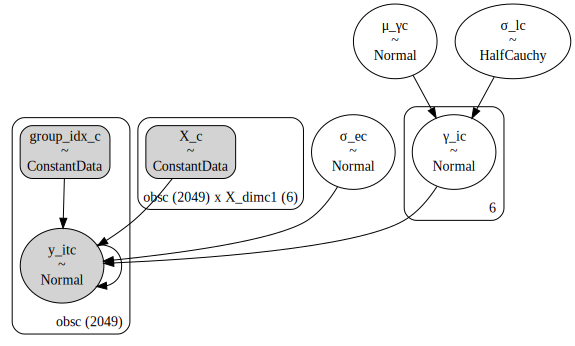

In [357]:
pm.model_to_graphviz(model_mo_1)

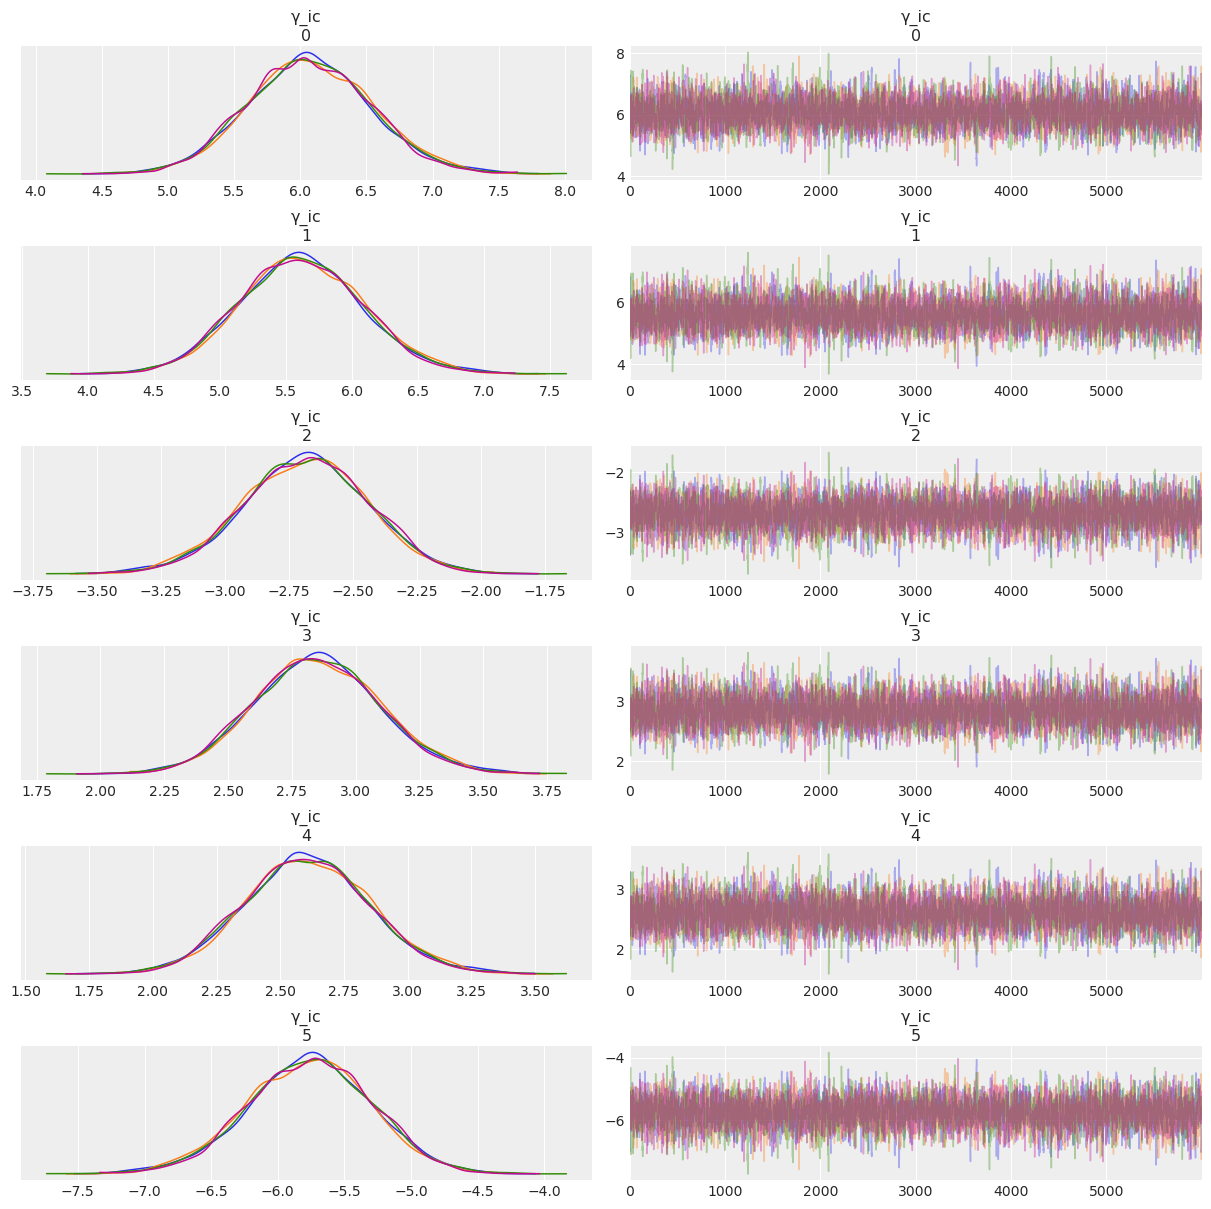

In [359]:
az.plot_trace(mo_trace1,var_names=['γ_ic'], combined=False,compact=False,divergences=False);

In [360]:
az.summary(mo_trace1, var_names=['γ_ic'], round_to = 3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
γ_ic[0],6.073,0.468,5.211,6.969,0.007,0.005,4161.879,5858.377,1.001
γ_ic[1],5.620,0.468,4.751,6.510,0.007,0.005,4154.443,6098.932,1.001
γ_ic[2],-2.685,0.245,-3.153,-2.234,0.004,0.003,4130.878,6043.639,1.001
γ_ic[3],2.849,0.246,2.401,3.328,0.004,0.003,4145.194,6174.307,1.001
γ_ic[4],2.607,0.247,2.153,3.081,0.004,0.003,4151.373,6317.387,1.001
γ_ic[5],-5.765,0.467,-6.657,-4.900,0.007,0.005,4151.714,6053.409,1.001


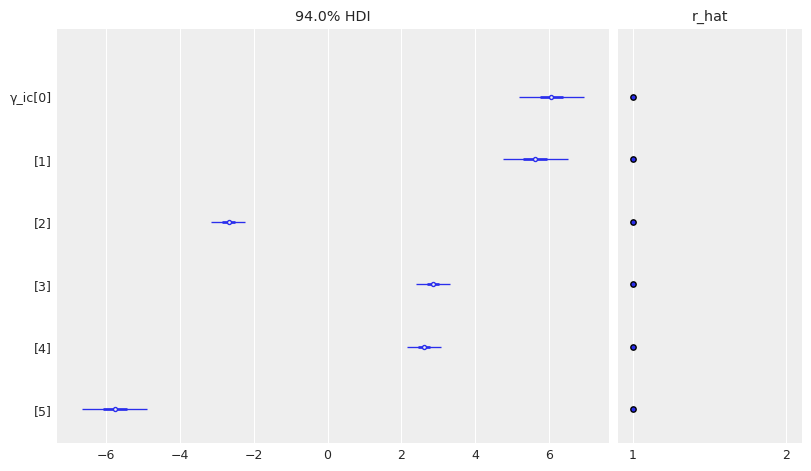

In [12]:
az.plot_forest(mo_trace1,var_names=['γ_ic'], r_hat=True, combined=True, textsize=9);

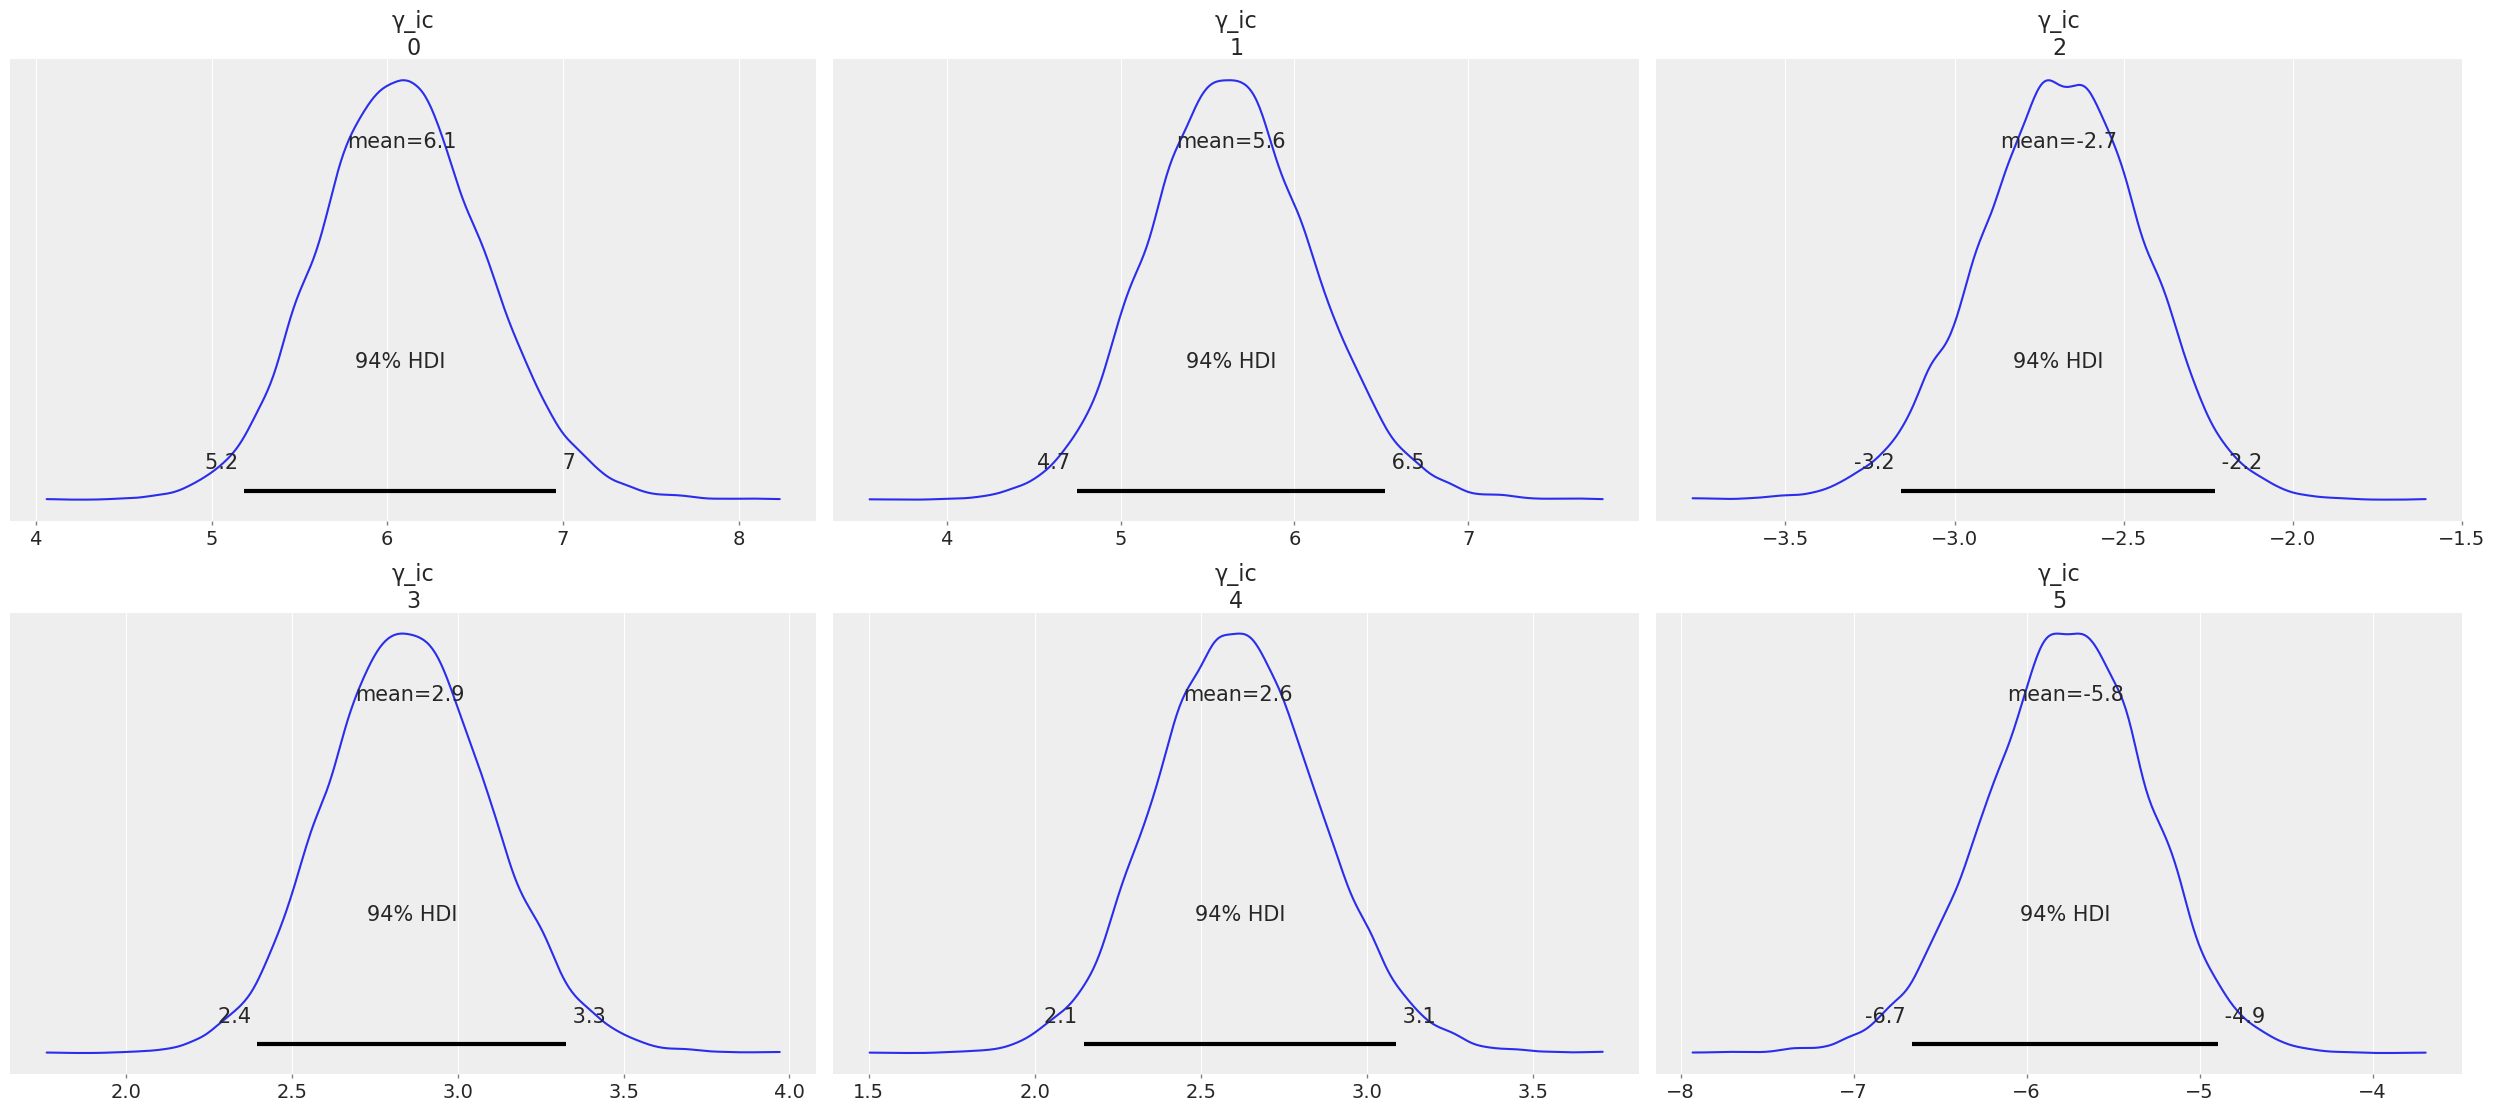

In [13]:
az.plot_posterior(mo_trace1, var_names=['γ_ic']);

### Quadratic model: model_mo_2

In [290]:
M2_df = dt3[["ind", "dem", "year_1", "year_2"]]

df_inter1 = dt3["ind"]*dt3["year_1"] 
df_inter2 = dt3["dem"]*dt3["year_1"]
df_inter3 = dt3["ind"]*dt3["year_2"] 
df_inter4 = dt3["dem"]*dt3["year_2"]

M2_df["inter1"] = df_inter1
M2_df["inter2"] = df_inter2
M2_df["inter3"] = df_inter3
M2_df["inter4"] = df_inter4
M2_df["intercept"] = pd.DataFrame({"intercept": np.ones(len(M2_df))}) # add intercept

M2 = M2_df.values

M2.shape

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1685803683.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M2_df["inter1"] = df_inter1
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1685803683.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M2_df["inter2"] = df_inter2
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/1685803683.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

(2049, 9)

In [291]:
pr_obsc = dt3['pr_agree'].values
coordsM2 ={"groupm": group_m,
         "X_dimc1": np.arange(M2.shape[1]),"obsc": np.arange(len(dt3.pr_agree))}

In [292]:
with pm.Model (coords = coordsM2) as model_mo_2:
    
 # create group index
    group_idx_c= pm.ConstantData("group_idx_c", group_m, dims = "obsc") 
 # data   
    X_c = pm.ConstantData("X_c", M2, dims=("obsc", "X_dimc1"))
    
    ## Priors

    μ_γc = pm.Normal('μ_γc', 0, 10)
    
    σ_γc = pm.HalfCauchy('σ_lc', 3)

    γ_ic = pm.Normal('γ_ic', mu = μ_γc, sigma = σ_γc, shape=9)
    
    σ_ec = pm.Normal('σ_ec', 0, 10)
    
# linear predictor

    μ_itc = at.sigmoid(at.dot(X_c, γ_ic))[group_idx_c] 
    
    print(γ_ic.eval().shape)
    
# Likelihood
    print(μ_itc.eval().shape)
    y_itc = pm.Normal('y_itc', mu=μ_itc, sigma = σ_ec, observed = pr_obsc, dims="obsc" )
    mo_trace2 = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=1000000)

(9,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


(2049,)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_γc, σ_lc, γ_ic, σ_ec]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 8022 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain re

### Cubic model: model_mo_3 

In [293]:
M3_df = dt3[["ind", "dem", "year_1", "year_2", "year_3"]]

df_inter1 = dt3["ind"]*dt3["year_1"] 
df_inter2 = dt3["dem"]*dt3["year_1"] 
df_inter3 = dt3["ind"]*dt3["year_2"] 
df_inter4 = dt3["dem"]*dt3["year_2"] 
df_inter5 = dt3["ind"]*dt3["year_3"] 
df_inter6 = dt3["dem"]*dt3["year_3"] 

M3_df["inter1"] = df_inter1 
M3_df["inter2"] = df_inter2 
M3_df["inter3"] = df_inter3
M3_df["inter4"] = df_inter4
M3_df["inter5"] = df_inter5
M3_df["inter6"] = df_inter6

# add intercept
M3_df["intercept"] = pd.DataFrame({"intercept": np.ones(len(M3_df))}) # add intercept

# values
M3 = M3_df.values

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2639207662.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M3_df["inter1"] = df_inter1
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2639207662.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M3_df["inter2"] = df_inter2
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2639207662.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [295]:
M3.shape

(2049, 12)

In [296]:
coordsM3 ={"groupc": group_m,
         "X_dimc3": np.arange(M3.shape[1]),"obsc": np.arange(len(dt3.pr_agree))}

with pm.Model (coords = coordsM3) as model_mo_3:
    
 # create group index
    group_idx_c= pm.ConstantData("group_idx_c", group_m, dims = "obsc") 
 # data   
    X_c = pm.ConstantData("X_c", M3, dims=("obsc", "X_dimc3"))
    
    # Priors

    μ_γc = pm.Normal('μ_γc', 0, 10)
    
    σ_γc = pm.HalfCauchy('σ_lc', 3)

    γ_ic = pm.Normal('γ_ic', mu = μ_γc, sigma = σ_γc, shape=12)
    
    σ_ec = pm.Normal('σ_ec', 0, 10)
    
    # linear predictor

    μ_itc = at.sigmoid(at.dot(X_c, γ_ic))[group_idx_c] 
    
    # Likelihood

    y_itc = pm.Normal('y_itc', mu=μ_itc, sigma = σ_ec, observed = pr_obsc, dims="obsc" )
    
    mo_trace3 = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_γc, σ_lc, γ_ic, σ_ec]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 9507 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptan

### Compare 3 moral models 

In [297]:
compare_dict_mo = {"Linear": mo_trace1, "Cubic": mo_trace2, "Quadratic": mo_trace3}
az.compare(compare_dict_mo)

/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwi

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Quadratic,0,700.294719,8.891878,0.000000,8.318527e-01,29.156402,0.000000,False,log
Cubic,1,649.674504,7.305995,50.620215,1.681473e-01,29.908374,12.701415,False,log
Linear,2,325.806524,7.573784,374.488195,5.153877e-12,26.800523,25.155973,False,log


In [332]:
az.waic(mo_trace1)

Computed from 24000 by 2049 log-likelihood matrix

          Estimate       SE
elpd_waic   325.81    26.80
p_waic        7.57        -

In [333]:
az.loo(mo_trace1)

Computed from 24000 by 2049 log-likelihood matrix

         Estimate       SE
elpd_loo   325.81    26.80
p_loo        7.57        -

In [334]:
az.waic(mo_trace2)

Computed from 24000 by 2049 log-likelihood matrix

          Estimate       SE
elpd_waic   649.67    29.91
p_waic        7.31        -

In [335]:
az.loo(mo_trace2)

/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Computed from 24000 by 2049 log-likelihood matrix

         Estimate       SE
elpd_loo   649.67    29.91
p_loo        7.31        -

In [336]:
az.waic(mo_trace3)

Computed from 24000 by 2049 log-likelihood matrix

          Estimate       SE
elpd_waic   700.30    29.16
p_waic        8.89        -

In [337]:
az.loo(mo_trace3)

/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Computed from 24000 by 2049 log-likelihood matrix

         Estimate       SE
elpd_loo   700.29    29.16
p_loo        8.89        -

In [355]:
mo_trace1.to_netcdf('mo_trace1.h5')
mo_trace2.to_netcdf('mo_trace2.h5')
mo_trace3.to_netcdf('mo_trace3.h5')

'mo_trace3.h5'

## Foreign policy models 

In [298]:
dt4 = pd.read_csv('n.m.dat4.csv') # foreign policy/security data
dt4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          141 non-null    int64  
 1   i.vars.label  141 non-null    object 
 2   i.vars.class  141 non-null    int64  
 3   data.source   141 non-null    object 
 4   pid           141 non-null    object 
 5   pr_agree      141 non-null    float64
 6   year_1        141 non-null    float64
 7   year_2        141 non-null    float64
 8   year_3        141 non-null    float64
 9   ind           141 non-null    int64  
 10  dem           141 non-null    int64  
 11  new           141 non-null    int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 13.3+ KB


### Linear model: model_fp_1

In [303]:
F1_df = dt4[["ind", "dem", "year_1"]]

df_inter1 = dt4["ind"]*dt4["year_1"] 
df_inter2 = dt4["dem"]*dt4["year_1"] 

F1_df["inter1"] = df_inter1
F1_df["inter2"] = df_inter2
F1_df["intercept"] = pd.DataFrame({"intercept": np.ones(len(F1_df))}) # add intercept

F1 = F1_df.values

F1.shape

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2190836156.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F1_df["inter1"] = df_inter1
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2190836156.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F1_df["inter2"] = df_inter2
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2190836156.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

(141, 6)

In [304]:
group_f = dt4.new.values -1 # 
group_f

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5])

In [305]:
pr_obsc = dt4['pr_agree'].values
coordsF1 ={"groupm": group_f,
         "X_dimc1": np.arange(F1.shape[1]),"obsc": np.arange(len(dt4.pr_agree))}

In [306]:
with pm.Model (coords = coordsF1) as model_fp_1:
    
 # create group index
    group_idx_c= pm.ConstantData("group_idx_c", group_f, dims = "obsc") 
 # data   
    X_c = pm.ConstantData("X_c", F1, dims=("obsc", "X_dimc1"))
    
    ## Priors

    μ_γc = pm.Normal('μ_γc', 0, 10)
    
    σ_γc = pm.HalfCauchy('σ_lc', 3)

    γ_ic = pm.Normal('γ_ic', mu = μ_γc, sigma = σ_γc, shape=6)
    
    σ_ec = pm.Normal('σ_ec', 0, 10)
    
# linear predictor

    μ_itc = at.sigmoid(at.dot(X_c, γ_ic))[group_idx_c] 
    
# Likelihood

    y_itc = pm.Normal('y_itc', mu=μ_itc, sigma = σ_ec, observed = pr_obsc, dims="obsc" )
    fp_trace1 = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_γc, σ_lc, γ_ic, σ_ec]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 494 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain rea

In [362]:
az.summary(fp_trace1, var_names=['γ_ic'], round_to = 3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
γ_ic[0],13.250,6.792,1.580,26.929,0.136,0.103,2984.814,3096.220,1.002
γ_ic[1],-4.957,6.257,-17.307,6.396,0.137,0.115,2576.277,2187.513,1.005
γ_ic[2],2.247,5.950,-8.598,14.242,0.150,0.113,1993.690,1819.126,1.002
γ_ic[3],7.401,6.206,-3.665,19.869,0.157,0.134,2010.906,1791.414,1.003
γ_ic[4],-1.545,5.951,-12.971,9.864,0.150,0.116,1996.176,1824.364,1.002
γ_ic[5],5.710,6.256,-5.835,17.878,0.137,0.114,2578.096,2193.250,1.005


### Quadratic model: model_fp_2 

In [307]:
F2_df = dt4[["ind", "dem", "year_1", "year_2"]]

df_inter1 = dt4["ind"]*dt4["year_1"] 
df_inter2 = dt4["dem"]*dt4["year_1"]
df_inter3 = dt4["ind"]*dt4["year_2"] 
df_inter4 = dt4["dem"]*dt4["year_2"]

F2_df["inter1"] = df_inter1
F2_df["inter2"] = df_inter2
F2_df["inter3"] = df_inter3
F2_df["inter4"] = df_inter4
F2_df["intercept"] = pd.DataFrame({"intercept": np.ones(len(F2_df))}) # add intercept

F2 = F2_df.values

F2.shape

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2434924776.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F2_df["inter1"] = df_inter1
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2434924776.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F2_df["inter2"] = df_inter2
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2434924776.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

(141, 9)

In [308]:
pr_obsc = dt4['pr_agree'].values
coordsF2 ={"groupm": group_f,
         "X_dimc1": np.arange(F2.shape[1]),"obsc": np.arange(len(dt4.pr_agree))}

In [309]:
with pm.Model (coords = coordsF2) as model_fp_2:
    
 # create group index
    group_idx_c= pm.ConstantData("group_idx_c", group_f, dims = "obsc") 
 # data   
    X_c = pm.ConstantData("X_c", F2, dims=("obsc", "X_dimc1"))
    
    ## Priors

    μ_γc = pm.Normal('μ_γc', 0, 10)
    
    σ_γc = pm.HalfCauchy('σ_lc', 3)

    γ_ic = pm.Normal('γ_ic', mu = μ_γc, sigma = σ_γc, shape=9)
    
    σ_ec = pm.Normal('σ_ec', 0, 10)
    
# linear predictor

    μ_itc = at.sigmoid(at.dot(X_c, γ_ic))[group_idx_c] 
    
# Likelihood

    y_itc = pm.Normal('y_itc', mu=μ_itc, sigma = σ_ec, observed = pr_obsc, dims="obsc" )
    fp_trace2 = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_γc, σ_lc, γ_ic, σ_ec]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 528 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain rea

### Cubic model: model_fp_3

In [310]:
F3_df = dt4[["ind", "dem", "year_1", "year_2", "year_3"]]

df_inter1 = dt4["ind"]*dt4["year_1"] 
df_inter2 = dt4["dem"]*dt4["year_1"]
df_inter3 = dt4["ind"]*dt4["year_2"] 
df_inter4 = dt4["dem"]*dt4["year_2"]
df_inter5 = dt4["ind"]*dt4["year_3"] 
df_inter6 = dt4["dem"]*dt4["year_3"] 

F3_df["inter1"] = df_inter1
F3_df["inter2"] = df_inter2
F3_df["inter3"] = df_inter3
F3_df["inter4"] = df_inter4
F3_df["inter5"] = df_inter5
F3_df["inter6"] = df_inter6

F3_df["intercept"] = pd.DataFrame({"intercept": np.ones(len(F3_df))}) # add intercept

F3 = F3_df.values

F3.shape

/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2846223882.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F3_df["inter1"] = df_inter1
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2846223882.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F3_df["inter2"] = df_inter2
/var/folders/zs/5yj3xzpx7jl966fqs_fq7tqc0000gn/T/ipykernel_44307/2846223882.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

(141, 12)

In [311]:
pr_obsc = dt4['pr_agree'].values
coordsF3 ={"groupm": group_f,
         "X_dimc1": np.arange(F3.shape[1]),"obsc": np.arange(len(dt4.pr_agree))}

In [312]:
with pm.Model (coords = coordsF3) as model_fp_3:
    
 # create group index
    group_idx_c= pm.ConstantData("group_idx_c", group_f, dims = "obsc") 
 # data   
    X_c = pm.ConstantData("X_c", F3, dims=("obsc", "X_dimc1"))
    
    ## Priors

    μ_γc = pm.Normal('μ_γc', 0, 10)
    
    σ_γc = pm.HalfCauchy('σ_lc', 3)

    γ_ic = pm.Normal('γ_ic', mu = μ_γc, sigma = σ_γc, shape=12)
    
    σ_ec = pm.Normal('σ_ec', 0, 10)
    
# linear predictor

    μ_itc = at.sigmoid(at.dot(X_c, γ_ic))[group_idx_c] 
    
# Likelihood

    y_itc = pm.Normal('y_itc', mu=μ_itc, sigma = σ_ec, observed = pr_obsc, dims="obsc" )
    fp_trace3 = pm.sample(draws=6000, tune=3000, target_accept=.98, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_γc, σ_lc, γ_ic, σ_ec]


/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 537 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain rea

### Compare 3 foreign policy models 

In [313]:
compare_dict_fp= {"Linear": fp_trace1, "Cubic": fp_trace2, "Quadratic": fp_trace3}
az.compare(compare_dict_fp)

/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(le

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Quadratic,0,104.225361,5.499665,0.000000,1.0,8.883345,0.000000,False,log
Cubic,1,104.039504,5.414480,0.185857,0.0,8.831225,0.217788,False,log
Linear,2,74.075559,4.342724,30.149801,0.0,8.632467,7.701042,False,log


In [344]:
az.waic(fp_trace1)

Computed from 24000 by 141 log-likelihood matrix

          Estimate       SE
elpd_waic    74.08     8.63
p_waic        4.34        -

In [345]:
az.loo(fp_trace1)

Computed from 24000 by 141 log-likelihood matrix

         Estimate       SE
elpd_loo    74.08     8.63
p_loo        4.34        -

In [346]:
az.waic(fp_trace2)

/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 by 141 log-likelihood matrix

          Estimate       SE
elpd_waic   104.06     8.83
p_waic        5.40        -

There has been a warning during the calculation. Please check the results.

In [347]:
az.loo(fp_trace2)

/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 24000 by 141 log-likelihood matrix

         Estimate       SE
elpd_loo   104.04     8.83
p_loo        5.41        -

In [348]:
az.waic(fp_trace3)

/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 by 141 log-likelihood matrix

          Estimate       SE
elpd_waic   104.24     8.88
p_waic        5.49        -

There has been a warning during the calculation. Please check the results.

In [349]:
az.loo(fp_trace3)

/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/sun/miniforge3/envs/pymc-dev-py39/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Computed from 24000 by 141 log-likelihood matrix

         Estimate       SE
elpd_loo   104.23     8.88
p_loo        5.50        -

In [356]:
fp_trace1.to_netcdf('fp_trace1.h5')
fp_trace2.to_netcdf('fp_trace2.h5')
fp_trace3.to_netcdf('fp_trace3.h5')

'fp_trace3.h5'